# Understanding bias in global heat flow compilation

### Stål et al, 2022, Frontiers in Earth Science – Heat Flow in an Unsteady World

This notebook reproduce the analysis and figures for the paper and supplementary material. 

Hobart 20 May, 2022

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings  
import sys

from matplotlib import pyplot as plt
import matplotlib 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import SCM6

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature
import cartopy.io.shapereader as shpreader
import rasterio

from itertools import combinations

# https://pypi.org/project/ipfn/
from ipfn import ipfn

from pyproj import Geod
geod = Geod(ellps="WGS84")

# https://pypi.org/project/agrid/
from agrid.grid import Grid

In [12]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


milli = 1/1000
km = 1000

earth_area = 510072000 * km * km 
eart_land_area = 148940000 * km * km  
earth_radius = (6357 + 6378)/2

default_colors = 5*['#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

In [13]:
# Select attributes used in this study
used_cols = ['q','q_unc','lat','lng','elevation', 'A_dom', 'A_reg', 'A_cont', 'A_year']
df = pd.read_csv('IHFC_2021_GHFDB-2.csv', 
                 low_memory=False, 
                 usecols=used_cols)

print(len(df))
# Remove a few (12) measuremenst with missing data
df = df.dropna(subset=['q','lng', 'lat'])
print(len(df))

# Reset index
df = df.reset_index()


# Fix column with some strings
for used_col in ['q','q_unc','lat','lng','elevation', 'A_year']:
    df[used_col] = pd.to_numeric(df[used_col], errors='coerce')

# Convert to SI
df['q'] = df['q'] * milli
df['q_unc'] = df['q_unc'] * milli

# Get coordinates
ix = df['lng'].values
iy = df['lat'].values

# Format coordinates for rasterio sample
pairs = [(x, y) for x, y in zip(ix, iy)]

# make geodataframe of heatflow catalogue
gdf = gpd.GeoDataFrame(df, 
    geometry=gpd.points_from_xy(df.lng, df.lat)).set_crs('epsg:4326')

df = None # Bin day! 

74548
74536


In [14]:
def distance(lat1, lon1, lat2, lon2):
    '''
    Haversine formula returns distance between pairs of coordinates.
    coordinates as numpy arrays, lists or real
    '''
    p = 0.017453292519943295 # pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    return 12742.0176 * np.arcsin(np.sqrt(a)) # returns in km


In [44]:
def distance_k(lat1, lon1, lat2, lon2):
    '''
    Haversine formula returns distance between pairs of coordinates.
    coordinates as numpy arrays, lists or real
    returns in rad
    '''
    a = 0.5 - np.cos((lat2-lat1))/2 + np.cos(lat1)*np.cos(lat2) * (1-np.cos((lon2-lon1))) / 2
    return 2 * np.arcsin(np.sqrt(a)) # 12742.0176 * returns in km


def cap(r, radius=1):
    return 2* np.pi * radius**2 * (1 - np.cos(np.deg2rad(r)))

In [15]:
def weight_count(arr, 
                 weights = None, 
                 south = -np.pi/2, 
                 north = np.pi/2, 
                 no_data=None, 
                 n = 1):
    '''
    This function applies an area weighting to Mercator proceted rasters
    arr : 2D array read as integer array
    weights : 1D array, defaults to sin Mercator 
    n : sample only every n-th pixel value
    
    returnes array of unique values and weigheted number of pixels
    '''
      
    # Subsampling of large rasters
    if n !=1:
        arr = arr[::n,::n]
    
    if weights is None:
        weights =  np.cos(np.linspace(np.deg2rad(south), 
                                      np.deg2rad(north), 
                                      np.shape(arr)[1]))    

    unique = np.unique(arr.astype('int'))
    counts = np.zeros_like(unique).astype('float')

    for i, u in enumerate(unique):
        counts[i] = np.sum((arr==u)*weights[None,:])
        
    return unique, counts * n * n


In [16]:
def gauss_kernel_sum(array, sigma =400):
    '''
    Return sum of Gaussian kernel weights.
    array : numpy array with distances 
    sigma : sigma of kernel
    '''
    return np.sum(np.exp(-(array**2)/(2*sigma**2)))/n

In [17]:
# Make a buffer polygon for mine sites
# Some issues with the buffer method, so did it with gdal instead

# f_mining = '../data/Global_mining/global_mining_polygons_v1.gpkg'
# s = gpd.read_file(f_mining).set_crs('epsg:4326')

# # Need equal area, however distorted near the poles
# s = s.to_crs({'proj':'cea'})

# # Add buffer, merge overlapping
# s = s.buffer(50*km).geometry.unary_union

# # # Make dataframe from series
# s = gpd.GeoDataFrame(geometry=gpd.GeoSeries(s), crs={'proj':'cea'})

# # Back to 4326
# s = s.to_crs('epsg:4326')

# # # Set attribute for all polygons
# s['mine'] = 1

# s.to_file('mines_buffer.shp')

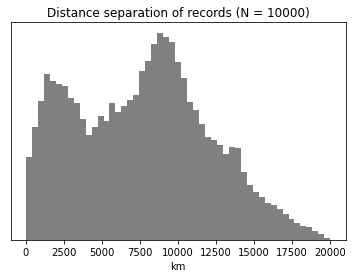

In [18]:
n = 10000
km = 1000

dens = n / 510_100_000 #Earths area km2  

lats = gdf['lat'].sample(n, random_state=12).values
lons = gdf['lng'].sample(n, random_state=12).values


lats = np.meshgrid(lats, lats)
lons = np.meshgrid(lons, lons)


mask = np.tril(np.ones((n,n)), k=-1).astype('bool') #mask the triangular matrix

dists = geod.inv(lons[0][mask].flatten(), lats[0][mask].flatten(), 
                lons[1][mask].flatten(), lats[1][mask].flatten())[-1]/km # 1D array with all distances in km

fig, ax = plt.subplots(1,1)

ax.hist(dists, bins=51, density=True, color = 'gray')
ax.set_title('Distance separation of records (N = {})'.format(n))
ax.set_xlabel('km')
ax.set_yticks([])



fig.savefig('fig/fig_s2.png')

Text(0.9, 0.1, 'Inhibition')

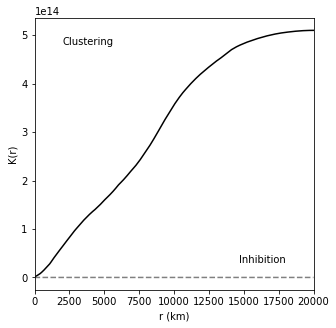

In [19]:
max_r = earth_radius * 2 * np.pi/2 

lamb = n/earth_area

rs = np.arange(0, max_r, 10)

K_t = np.ones(len(rs))
L_t = np.ones(len(rs))


for i, r in enumerate(rs): 
    # average number of points within radius x 2, as only half of distances calculated
    sum_r = 2 * np.sum(dists<r)/n
    
    # lambda correction for expected density
    K_t[i] = sum_r * earth_area / n 
    
    
fig, ax = plt.subplots(1,1, figsize = (5,5))

ax.plot(rs, K_t, c='k')

ax.set_xlabel('r (km)')

ax.set_ylabel('K(r)')
ax.set_xlim(0, max_r)

rad_rs = rs / 6371 # Quick conversion from km to arc in radians

# Area as spherical cap
cap_areas = 2 * np.pi * earth_radius**2 * (1 - np.cos(rad_rs))

ax.plot(rs, cap_areas, c = 'gray', ls = '--');

ax.text(0.1, 0.9, 'Clustering', transform=ax.transAxes)
ax.text(0.9, 0.1, 'Inhibition', transform=ax.transAxes, ha = 'right')

Text(0.2, 0.9, 'Clustering')

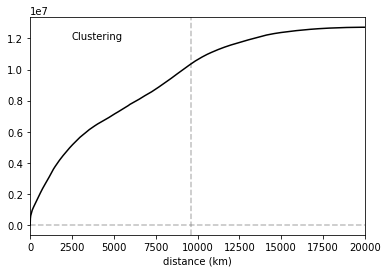

In [20]:
fig, ax = plt.subplots(1,1)

L_t = (K_t/np.pi)**0.5

ax.axhline(y=0, color='gray', linestyle='--', alpha = 0.5)
ax.axvline(x=9600, color='gray', linestyle='--', alpha = 0.5)

ax.plot(rs, L_t - rs, c='k')

ax.set_xlabel('distance (km)')
ax.set_xlim(0, max_r)

ax.text(0.2, 0.9, 'Clustering', transform=ax.transAxes, ha='center')


#rad_rs = rs / 6371 # Quick conversion from km to arc in radians
#cap_areas = 2 * np.pi * earth_radius**2 * (1 - np.cos(rad_rs))
#ax.plot(rs, cap_areas, c = 'gray', ls = '--')

In [21]:
%%time
# Wall time: 4min 58s

W_50 = np.zeros(len(gdf))
W_200 = np.zeros(len(gdf))
W_1000 = np.zeros(len(gdf))

for i, row in gdf.iterrows():
    d = distance(gdf['lat'].values, gdf['lng'].values, row['lat'], row['lng']) 
    W_50[i] = gauss_kernel_sum(d, sigma=50) # weight all (other) measurements by distance
    W_200[i] = gauss_kernel_sum(d, sigma=200)
    W_1000[i] = gauss_kernel_sum(d, sigma=1000)

    
# Weight as inverse    
W_50 = 1/W_50
W_200 = 1/W_200
W_1000 = 1/W_1000

# Normalise with mean, and populate dataframe
gdf['w_50km'] = W_50/np.nanmean(W_50) 
gdf['w_200km'] = W_200/np.nanmean(W_200)
gdf['w_1000km'] = W_1000/np.nanmean(W_1000)   

CPU times: user 5min 20s, sys: 11.1 s, total: 5min 32s
Wall time: 5min 32s


In [22]:
%%time
#Wall time: 4min 15s

world = Grid(res=(1, 1))

# Number of shortest distances to average in Fig. 1D
k = 10

A = np.zeros(world.nn + (k,))
K = np.zeros(world.nn)
n = len(gdf)


for i, x in enumerate(world.ds.X.values):
    for j, y in enumerate(world.ds.Y.values):
        d = distance(gdf['lat'].values, gdf['lng'].values,y, x)
        
        # This is too slow. Spherical approximation is good enough. 
        # d = geod.inv(gdf['lng'].values.flatten(), 
        #             gdf['lat'].values.flatten(), 
        #        [y]*n, [x]*n)[-1]

        
        
        A[j,i, :] = np.partition(d, k, axis=None)[:k] # Select the closest 10 measurements
        K[j,i] = gauss_kernel_sum(d) # Calculate KDE
        
    

dev version
CPU times: user 4min 5s, sys: 5.53 s, total: 4min 10s
Wall time: 4min 10s


In [23]:
# Get closest distance and average of closest 10
d_min = np.min(A, axis=2)
d_10 = np.mean(A, axis=2)

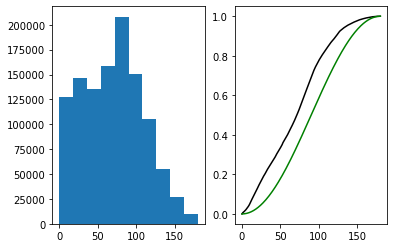

In [59]:
#subsample some number 
k_coord = gdf.sample(n= 1500)[['lat', 'lng']]

k_lats = np.deg2rad(k_coord['lat'].values)
k_lons = np.deg2rad(k_coord['lng'].values)


n = np.shape(k_lats)[0]

m_lats = np.meshgrid(k_lats, k_lats)
m_lons = np.meshgrid(k_lons, k_lons)

mask = np.tril(np.ones((n,n)), k=-1).astype('bool') #mask the triangular matrix, exclude diagonal 

dists = distance_k(m_lats[0][mask].flatten(), m_lons[0][mask].flatten(), 
                 m_lats[1][mask].flatten(), m_lons[1][mask].flatten())

rs = np.linspace(0, 180, 180)
sp = cap(rs)*2
sp = sp/np.max(sp)

Ht = []



for r in rs:
    k = 2 * np.sum(np.rad2deg(dists)<r)/(n*(n-1))
    Ht.append(k)

  



fig, ax = plt.subplots(1,2)
ax[0].hist(np.rad2deg(dists))
ax[1].plot(rs, Ht, 'k-')
ax[1].plot(rs, sp, 'g-')



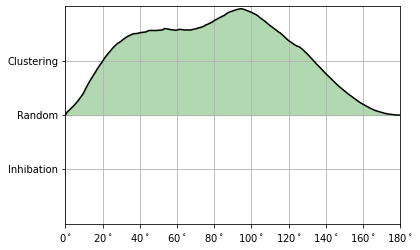

Dmax 1341.376191273055 [[53 32]] -147.91086 -36.70391
D10 1687.8979483316277 [[  5 187]] 7.520891 -84.97207


/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/3935828155.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


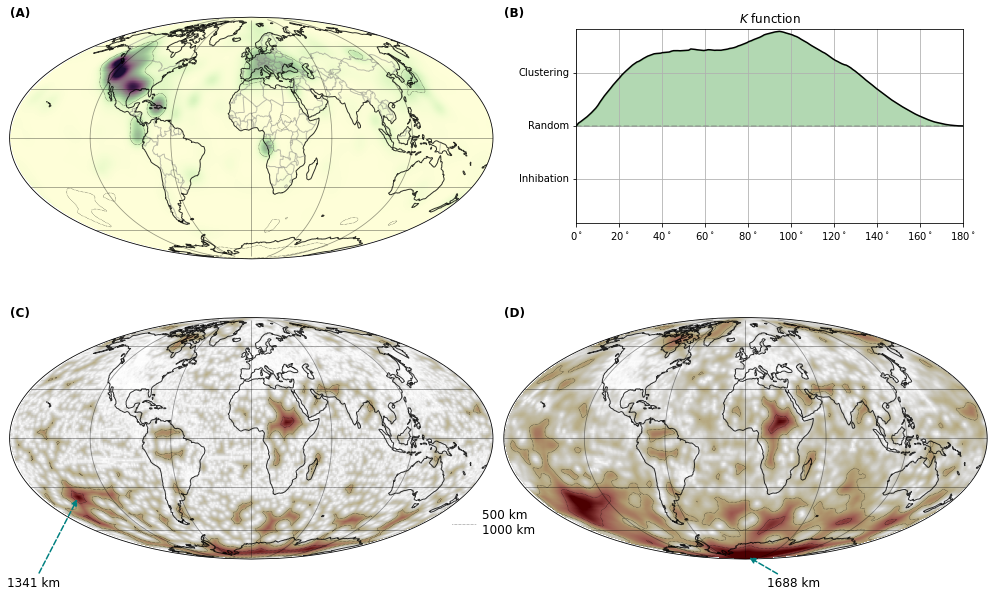

In [66]:
fig, ax = plt.subplots(2,2, figsize = (14,9),  
                       subplot_kw = dict(projection=ccrs.Mollweide()))



ax[0,0].imshow(K,
           transform = ccrs.PlateCarree(), 
           origin='lower', 
            vmin = np.percentile(K, 0.1),
            vmax = np.percentile(K, 99.9),
        extent= world.extent, 
           cmap = SCM6.tokyo_r)


K_min = np.percentile(K, 0.05)

# extend = 'max'

kde = ax[0,0].contour(K, 
            levels = [np.percentile(K, 5), np.percentile(K, 95)], linewidths=0.5, 
                colors='k', 
                extent= world.extent, 
                linestyles = [':', ':'],
                origin='lower', 
                zorder=1, 
                transform = ccrs.PlateCarree())


# Get closest distance and average of closest 10
d_min = np.min(A, axis=2)
d_10 = np.mean(A, axis=2)

# Find index for largest distance
d_max_index = np.argwhere(d_min == np.max(d_min))
d_10_index = np.argwhere(d_10 == np.max(d_10))

# Read coordinates
max_lon = world.ds.X.values[d_max_index[0][1]]
max_lat = world.ds.Y.values[d_max_index[0][0]]

max10_lon = world.ds.X.values[d_10_index[0][1]]
max10_lat = world.ds.Y.values[d_10_index[0][0]]


print('Dmax', d_min.max(), d_max_index, max_lon, max_lat)
print('D10', d_10.max(), d_10_index, max10_lon, max10_lat)




ax[1,0].imshow(d_min,
           transform = ccrs.PlateCarree(), 
               extent= world.extent, 
           origin='lower', 
           cmap = SCM6.bilbao,
           vmin = 0, vmax = np.max(d_min))

CTmin = ax[1,0].contour(d_min, 
            levels = [500, 1000], linewidths=0.5, 
                colors='k', 
                extent= world.extent, 
                linestyles = [':', ':'],
                origin='lower', 
                zorder=1, 
                transform = ccrs.PlateCarree()) 

ax[1,0].annotate('%.0f km'%d_min.max(), 
                 xy=(max_lon, max_lat), 
                 xycoords= ccrs.PlateCarree()._as_mpl_transform(ax[1,0]), 
            xytext=(0.05, -0.1), 
                 textcoords=ax[1,0].transAxes, 
                 fontsize='large',
            ha='center', 
                 va='center', 
                 color='k', 
                arrowprops=dict(arrowstyle= '-|>',
                             color='teal',
                             lw=1.5,
                             ls='--'))


# ax[1,0].scatter(max_lon, max_lat, 
#                 marker ='*',
#                 s = 120,
#                 edgecolor = 'cyan',
#                 zorder=1, 
#                 transform = ccrs.PlateCarree())

ax[1,1].imshow(d_10,
           transform = ccrs.PlateCarree(), 
            extent= world.extent, 
           origin='lower', 
           cmap = SCM6.bilbao,
           vmin = 0, vmax = np.max(d_min)) # same vmax as Fig 1C


CT10 = ax[1,1].contour(d_10, 
            levels = [500, 1000], linewidths=0.5, 
                colors='k', 
                extent= world.extent, 
                linestyles = [':', ':'],
                origin='lower', 
                zorder=1, 
                transform = ccrs.PlateCarree()) 



ax[1,1].annotate('%.0f km'%d_10.max(), 
                 xy=(max10_lon, max10_lat), 
                 xycoords= ccrs.PlateCarree()._as_mpl_transform(ax[1,1]), 
            xytext=(0.6, -0.1), 
                 textcoords=ax[1,1].transAxes, 
                 fontsize='large',
            ha='center', 
                 va='center', 
                 color='k', 
                arrowprops=dict(arrowstyle= '-|>',
                             color='teal',
                             lw=1.5,
                             ls='--'))


# ax[1,1].scatter(max10_lon, max10_lat, 
#                 marker ='*',
#                 s = 120,
#                 edgecolor = 'cyan',
#                 zorder=1, 
#                 transform = ccrs.PlateCarree())




ax[1,1].plot([0,0], [0,0], 
         zorder = 0,
         color='k', 
         linestyle = ':',
         linewidth=0.5, 
         label = '500 km\n1000 km')


    
fig.legend(*ax[1,1].get_legend_handles_labels(), 
           loc = 'lower center', 
           bbox_to_anchor = (0,0.1,1,0.1),
           handletextpad=0.5,
                 framealpha=1, 
                 prop={'size': 12},
            bbox_transform = plt.gcf().transFigure,
           frameon=False)
    
    
    
#L_t = (K_t/np.pi)**0.5

axins = inset_axes(ax[0,1], 
                   width="100%", 
                   height="100%",
                   bbox_to_anchor=(0.15, 0.15, 0.8, 0.8),
                   bbox_transform=ax[0,1].transAxes, 
                   borderpad=0.0)

axins.axhline(y=0, color='gray', linestyle='--', alpha = 0.5)

# for arc_d in [90]: 86.67 Vianna to San Fransico
#     axins.axvline(x=arc_d, color='teal', linestyle='--', 
#              alpha = 0.5)
#     axins.text(arc_d*1.05, -0.15, '90$^{\circ}$ distance', color='teal')
    



# #Lt_rs = L_t - rs
# axins.plot(rs, Lt_rs/np.max(Lt_rs), c='k')

# axins.set_ylabel('$\widehat{L}(t)$', labelpad=0)
# axins.set_xlabel('distance (km)')
# axins.set_xlim(0, max_r)
# #ax4.set_ylim(-0.1, 1)

axins.plot(rs, Ht - sp, 'k-')

axins.set_yticks([-0.11, 0, 0.11])
axins.set_yticklabels(['Inhibation', 'Random', 'Clustering'], va='center')

axins.set_xlim(0,180)

axins.set_ylim(-0.2, 0.2)

def mjrFormatter(x, pos):
    return '{}$^\circ$'.format(int(x))

axins.fill_between(rs, Ht - sp, color='green', alpha=0.3)

axins.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(mjrFormatter))

axins.grid()






# axins.text(0.2, 0.8, 'Clustering', transform=axins.transAxes, ha='center')
# axins.text(0.7, 0.05, 'Inhibition', transform=axins.transAxes, ha='center')
axins.set_title('$K$ function')


for a, label in zip([ax[0,0], ax[1,0], ax[1,1]], list('ACD')):
    a.text(0, 1, '(%s)'%label,transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.set_global()
    a.coastlines(resolution='auto', 
                 color='k', 
                 alpha = 0.8)
    a.gridlines(color='k', 
                linestyle='-', 
                draw_labels=False, 
                alpha = 0.4)


ax[0,0].add_feature(cartopy.feature.BORDERS, color='gray', alpha = 0.5)

ax[0,1].text(0, 1, '(B)',
        transform=ax[0,1].transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
ax[0,1].axis('off')   
    
fig.tight_layout()
fig.savefig('fig/fig_1.png', dpi=300)

In [71]:
province_order = ['orogenic belt', 'shield', 'craton', 'volcanic arc', 'oceanic crust', 
 'narrow rift', 'foredeep basin', 'passive margin', 'ophiolite complex', 
 'accretionary complex', 'basin', 'back-arc basin', 'wide rift', 
 'magmatic province', 'oceanic back-arc basin']
   
province_labels = ['orogenic belt', 'shield', 'craton', 'volcanic arc', 'oceanic crust', 
 'narrow rift', 'foredeep basin', 'passive margin', 'ophiolite complex', 
 'accretionary cmplx.', 'basin', 'back-arc basin', 'wide rift', 
 'magmatic province', 'oceanic back-arc bsn.']
    
    
orogen_order = ['Kuunga', 'Yavapai-Mazatzal', 'Trans Hudson', 'Limpopo', 'cratonic', 
                'East African', 'Variscan-Hercynian', 'Birimian', 'Grenvillian', 'Brasiliano', 
                'Afar', 'Alpine-Himalayan', 'Terra Australis', 'Saharide', 'Cordilleran', 
                'failed rift', 'Kazakh', 'Baikal', 'Mongol', 'Indosinian', 
                'Solonker', 'Caledonian', 'Uralian', 'Picuris', 'Wopmay', 'Antilles', 'Scotian']

orogen_labels =['Kuunga', 'Yavapai-Mazatzal', 'Trans Hudson', 'Limpopo', 'cratonic', 
                'East African', 'Variscan-Hercynian', 'Birimian', 'Grenvillian', 'Brasiliano', 
                'Afar', 'Alpine-Himalayan', 'Terra Australis', 'Saharide', 'Cordilleran', 
                'failed rift', 'Kazakh', 'Baikal', 'Mongol', 'Indosinian', 
                'Solonker', 'Caledonian', 'Uralian', 'Picuris', 'Wopmay', 'Antilles', 'Scotian']

gprv =  {'file' : '../data/global_tectonics-main/plates&provinces/global_gprv_wage.shp',
               'attributes' : [
                   {'attribute': 'prov_type',
                    'title':'PROVINCE' ,
                   'order' : province_order, 
                   'labels' : province_labels},
                   
                   {'attribute': 'lastorogen',
                    'title':'OROGEN' ,
                   'order' : orogen_order, 
                   'labels' : orogen_labels},  
                    {'attribute': 'crust_type',
                    'title':'CRUST' },  
                   
               ]
        }
        
   
plate_type_order = ['microplate', 'rigid plate', 'deformation zone']
plate_type_labels = ['microplate', 'rigid plate', 'deform. zone']

plates_order = ['Eurasian Plate', 'Arabian Plate', 'Pacific Plate', 
                'North American Plate', 'Antarctic Plate', 
                'Nazca Plate', 'Scotia Plate', 'Australian Plate', 
                'South American Plate', 'Philippine Plate', 
                'Caribbean Plate', 'Juan de Fuca Plate', 'Cocos Plate', 
                'African Plate', 'Somali Plate', 'Indian Plate']
plates_labels = ['Eurasian',
 'Arabian',
 'Pacific',
 'N. American',
 'Antarctic',
 'Nazca',
 'Scotia',
 'Australian',
 'S. American',
 'Philippine',
 'Caribbean',
 'Juan de Fuca',
 'Cocos',
 'African',
 'Somali',
 'Indian']
    
plates =  {'file': '../data/global_tectonics-main/plates&provinces/plates.shp',
               'attributes' : [
                   {'attribute' : 'plate_type',
                    'title' : 'TYPE',  
                    'order' : plate_type_order,
                    'labels' : plate_type_labels
                   },
                   
                   {'attribute': 'plate',
                    'title' : 'PLATE',
                    'order' : plates_order, 
                    'labels' : plates_labels,
                   }   
               ]
          }
               



In [72]:
mines =  {'file': 'gis/mining_buffer_03.shp',
           'attribute' : 'mine',
            'no_data' : 0,
            'title' : 'Mines', }

oil_fields = {'file': 'gis/oil_fields_buffer_0.1.shp',
                'set_to_one': True,
                'attribute' : 'oil_gas',
                'no_data' : 0,
                'title' : 'Oil and gas fields'}

In [73]:
# reg_labels = {
# 1 : 'Cratons',
# 2 : 'Precambrian F&T Belts and Modified Cratons',
# 3 : 'Phanerozoic Continents',
# 4 : 'Ridges & Backarcs',
# 5 : 'Oceanic',
# 6 : 'Oldest Oceanic',
# }

values = {
1 : 'c',
2 : 'pbmc',
3 : 'pc',
4 : 'rb',
5 : 'o',
6 : 'oo',
}

color_list = ['#e26e01', '#d37fa0', '#c08fb0',
              '#4daf4a','#984ea3', '#379ef8']


reg_labels = ['cratons',
 'belts & mod. crt.',
 'phanerozoic',
 'ridges & backarcs',
 'oceanic',
 'old oceanic']


reg = {'file' : '../data/sl2013sv-tectonic-regionalization/SL2013sv_TectRegn_2d/SL2013sv_Cluster_2d', 
       'title' : 'REG', 
       'values' : values,
        'labels' : reg_labels, 
        'colors' : color_list,
        'order' : ['c', 'pbmc', 'pc', 'rb', 'o', 'oo']
       }


In [74]:
# "OBJECTID";"Value_";"Count_";"xx"
# 1;1;35356728.000000;"su"
# 2;2;6329752.000000;"vb"
# 3;3;28570923.000000;"ss"
# 4;4;1601483.000000;"pb"
# 5;5;28732659.000000;"sm"
# 6;6;12488621.000000;"sc"
# 7;7;1692419.000000;"va"
# 8;8;22056333.000000;"mt"
# 9;9;10398877.000000;"pa"
# 10;10;3121157.000000;"vi"
# 11;11;1419152.000000;"wb"
# 12;12;962991.000000;"py"
# 13;13;689039.000000;"pi"
# 14;14;388790.000000;"ev"
# 15;15;112415.000000;"nd"
# 16;16;61757030.000000;"ig"
# 



glim_values = {
    1 : 'su',
    2 : 'vb',
    3 : 'ss',
    4 : 'pb',
    5 : 'sm',
    6 : 'sc',
    7 : 'va',
    8 : 'mt',
    9 : 'pa',
    10: 'vi',
    11: 'wb',
    12: 'py',
    13: 'pi',
    14: 'ev',
    15: 'nd',
    16: 'ig',
    -9999 : 'oc'
}

glim_color_list = ['#ef6f00', '#df7f00', '#cf8f00', '#bf9f00','#afaf00', '#9fbf00',
              '#c73e38',
              '#4daf4a', '#4daf4a', '#4daf4a',
              '#984ea3', '#984ea3', '#984ea3', 
              '#578e98', '#478ed8', '#379ef8',
              'gray']

glim_order = ['su', 'ss', 'sm', 'sc', 'py', 'ev',
           'mt',
           'vb', 'vi', 'va', 
           'pb', 'pi', 'pa', 
           'wb','ig', 
           'nd'
          ]

glim_labels = ['unconsolidated sed.', 'siliciclastic sed.', 
               'mixed sed.', 'carbonate sed.', 'pyroclastic', 'evaporites',
           'metamorphics',
           'basic volcanic', 'inter. volcanic', 'acid volcanic', 
           'basic plutonic', 'inter. plutonic', 'acid plutonic', 
           'water Bodies','ice & Glaciers', 
           'no data'
          ]


glim = {'file' : '../data/hartmann-moosdorf_2012/glim_wgs84_0point5deg.txt.asc', 
       'title' : 'GLiM', 
        'no_data' : -9999, 
        'values' : glim_values, 
        'labels' : glim_labels, 
        'colors' : glim_color_list,
        'order' : glim_order
       }


In [75]:
#  1  flat
#  2  summit
#  3  ridge
#  4  shoulder
#  5  spur
#  6  slope
#  7  hollow
#  8  footslope
#  9  valley
#  10 depression
# https://grass.osgeo.org/grass78/manuals/r.geomorphon.html


# CONFIRM! (works as labels too)
values = {
0 : 'ocean',
1 : 'flat',
2 : 'peak',
3 : 'ridge',
4 : 'shoulder',
5 : 'spur',
6 : 'slope',
7 : 'hollow', 
8 : 'footslope', 
9 : 'valley', 
10 : 'pit',
}

color_list = ['#e26e01', '#37aef8', '#d37fa0', '#c08fb0',  '#37aef8', 
              '#4daf4a','#984ea3', '#379ef8',  '#379e28',  '#3b9ef8', 'blue']



topo_order = ['flat', 'peak', 'ridge', 'shoulder', 'spur', 'slope', 'hollow', 'valley', 'pit']

topo_labels = [label for label in topo_order]

topo = {'file' : '../data/dtm_merit/dtm_geom_merit.dem_m_250m_s0..0cm_2018_v1.0.tif', 
       'title' : 'TOPO', 
        'values' : values,
        'labels' : topo_labels, 
        'subsample_n' : 40,
        'extent' : (-180.0, -62, 180.0, 87.37),
        'no_data' : 0, 
        'colors' : color_list,
        'order' : topo_order
       }


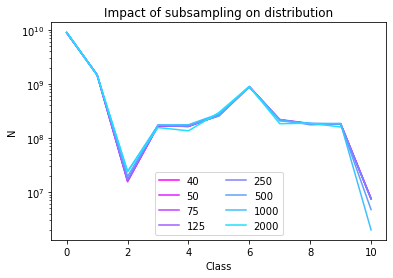

In [76]:
arr = rasterio.open('../data/dtm_merit/dtm_geom_merit.dem_m_250m_s0..0cm_2018_v1.0.tif').read(1)

fig, ax = plt.subplots(1,1)

cmap = matplotlib.cm.get_cmap('cool_r')

tests = [40, 50, 75, 125, 250, 500, 1000, 2000]

for i, n in enumerate(tests):
    u, c =  weight_count(arr, no_data=-9999, n = n)
    ax.plot(u,c, label = n, c = cmap(i/len(tests)))
    ax.legend(ncol = 2)
    
ax.set_yscale('log')
ax.set_title('Impact of subsampling on distribution')
    
ax.set_ylabel('N')
ax.set_xlabel('Class')

fig.savefig('fig/fig_s1.png')

arr = None

In [77]:
! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

building file list ... 
15 files to consider
fig/fig_s1.png
      16.59K 100%    0.00kB/s    0:00:00 (xfer#1, to-check=7/15)

sent 17.06K bytes  received 42 bytes  34.20K bytes/sec
total size is 49.98M  speedup is 2922.71


In [78]:
obs = pd.DataFrame(columns = ['file', 
                              'title', 
                              'values',
                              'labels', 
                              'subsample_n', 
                              'no_data', 
                              'extent',
                              'res',
                              'colors', 
                              'order'])



def raster_to_row(d, ix=ix, iy=iy, pairs=pairs):
    d.setdefault('subsample_n', 1)
    d.setdefault('no_data', 0)
 
    src = rasterio.open(d['file'])
 
    d['extent'] = src.bounds
    d['res'] = src.res
    
    # Dirty fix to move measurements given lon = 180. Moving half pixel doesn't change value. 
    ix = np.clip(ix, src.bounds[0]+src.res[0]/2, src.bounds[2]-src.res[0]/2)
    iy = np.clip(iy, src.bounds[1]+src.res[1]/2, src.bounds[3]-src.res[1]/2)
    
    # Sample values at each heat flow measurement. With masked=True, samples outside raster become nan
    gdf[d['title']] = np.array([smpls[0] for smpls in list(rasterio.sample.sample_gen(src, 
                                                                               xy=pairs, 
                                                                               masked=True))])
    # Remove nan and convert ID's to strings (as provided with models)
    gdf[d['title']] = gdf[d['title']].fillna(value=d['no_data'])    
    
    for old, new in d['values'].items():
        gdf[d['title']] = gdf[d['title']].replace(old, new, regex=False)
    
    
    
    # Make dict from raster classes and count
    samples_r = {int(c[0]) : c[1] for c in zip(*weight_count(src.read(1), 
                                                        south = src.bounds[1],
                                                        north = src.bounds[3],
                                                        n = d['subsample_n']))}

    # Rename keys according to table
    samples_r = {d['values'][k]:v for k, v in samples_r.items()}
    
    # Make empty dict with all classes...
    samples_s = {x: 0 for x in samples_r}
    
    # ...and populate with sampled values 
    samples_s.update({c[0] : int(c[1]) for c in zip(*np.unique(gdf[d['title']], 
                                                                    return_counts=True))})

    # add number of pixels/samples to dataframe, rename keys
    d['reference_n'] = samples_r 
    d['sample_n'] = samples_s 
    
    # add an attribute value for consistance with vector attributes
    d['attribute'] = d['title']
    
    return d 

def raster_to_obs(d, obs, force = False):
    if d['title'] not in list(obs['title']):
        print('adding', d['title'])
        return pd.concat([obs, pd.DataFrame.from_records([raster_to_row(d)])])
    elif d['title'] in list(obs['title']) and force:  
        # replace row
        return obs
    else:
        print('already in obs', d['title'])
        return obs
        
  
def vector_to_rows(d, ix=ix, iy=iy, pairs=pairs, v_crs = 'epsg:4326'):
    d.setdefault('no_data', 0)
    
    v = gpd.read_file(d['file'])
        
    try:
        v = v.set_crs(v_crs)
    except:
        v = v.to_crs(v_crs)
    
    # list of attributes requested
    attributes = [in_dict['attribute'] for in_dict in d['attributes']]
    
    #sample atributes remove columns first, to not make new column from join
    sampled_values = gpd.sjoin(gdf.drop(columns=attributes, errors = 'ignore'), v, 
                               how="left", predicate='intersects')[attributes]
      
        
    # there are a few (5?) duplicated indexes, easiest just to remove them 
    sampled_values = sampled_values[~sampled_values.index.duplicated(keep='first')]
    
    
    
    # Eproject to equal area and calculate area
    v_ea = v.to_crs({'proj':'cea'})
    v_ea['poly_area'] = v_ea['geometry'].area
    
    attr_list = []
    for attr in d['attributes']:
        # attr is a dict for each attribute
    
        # Make dict of classes and total area of each class /1e6 to get km2
        samples_v = {c : v_ea['poly_area'].where(v_ea[attr['attribute']] == c).sum()/1e6 
                     for c in v_ea[attr['attribute']].dropna().unique().tolist()}
    
        # add samapled values to database
        gdf[attr['attribute']] = sampled_values[attr['attribute']].fillna(value=d['no_data'])
    
        # Set 0 for all existing vectors
        samples_s = {x: 0 for x in samples_v}

        # ...and populate with sampled values 
        samples_s.update({k : int(v) for k, v in sampled_values[attr['attribute']].value_counts().to_dict().items()})
    
        attr = {**attr, **{'sample_n' : samples_s, 
                'reference_n':  samples_v, 
                'file': d['file']}
               }
    
        attr.setdefault('colors', default_colors)
        attr.setdefault('order', attr['reference_n'].keys())
        attr.setdefault('labels', attr['order'])

        attr_list.append(attr)    
    return attr_list
    
    
    
def vector_to_obs(d, obs, force = False):
    attributes = [in_dict['title'] for in_dict in d['attributes']]
    for attribute in attributes:
        if attribute not in list(obs['title']) or force:
            print('adding', attribute)
            return pd.concat([obs, pd.DataFrame.from_records(vector_to_rows(d))]) 
        elif attribute in list(obs['title']) and force:
            # replace row
            return obs
        else:
            print('already in obs', attribute)
            return obs
             
        
def cover_to_dict(d, obs, v_crs = 'epsg:4326'):
    d.setdefault('no_data', 0)
    v = gpd.read_file(d['file'])
        
    try:
        v = v.set_crs(v_crs)
    except:
        v = v.to_crs(v_crs)
    

    
    d.setdefault('attribute', list(v)[-1])
    attr = d['attribute']
    
    # Replace any value with 1
    v[attr] = v[attr].notnull().astype('int')

    #sample atributes remove columns first, to not make new column from join
    sampled_values = gpd.sjoin(gdf.drop(columns=attr, errors = 'ignore'), v, 
                               how="left", predicate='intersects')[attr]
      
    # there are a few (5?) duplicated indexes, easiest just to remove them 
    sampled_values = sampled_values[~sampled_values.index.duplicated(keep='first')]
    
    # Set sampled nans to 0
    sampled_values = sampled_values.notnull().astype('int')

    sampled_sum = sampled_values.sum()
    no_sampled_sum = len(sampled_values) - sampled_sum
    
    # Eproject to equal area and calculate area
    v_ea = v.to_crs({'proj':'cea'})
    v_area = v_ea['geometry'].area.sum()
    
    # add samapled values to database as strings
    map_dict = {0: 'no_'+attr, 1:attr}
    sampled_values =  sampled_values.map(map_dict)
    gdf[attr] = sampled_values.fillna(value=d['no_data'])
    

    d_attr = {**d, **{'sample_n' : {attr : sampled_sum, 
                                    'no_'+attr : no_sampled_sum}, 
                'reference_n':  {attr : v_area, 
                                 'no_'+attr : earth_area - v_area}
                     }}
    
    d_attr.setdefault('colors', default_colors[:2])
    d_attr.setdefault('order', ['no_'+attr, attr])
    d_attr.setdefault('labels', ['No ' + attr, attr])
    
    return d_attr
    
    
   
for vector in [gprv, plates]:
    obs = vector_to_obs(vector, obs) 

for raster in [reg, glim, topo]:
    obs = raster_to_obs(raster, obs)

for vector in [mines, oil_fields]:
    cover_d = cover_to_dict(vector, obs)
    obs = pd.concat([obs, pd.DataFrame.from_records([cover_d])]) 


adding PROVINCE
adding TYPE
adding REG
adding GLiM


/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/2438461447.py:28: UserWarning: Warning: converting a masked element to nan.
  gdf[d['title']] = np.array([smpls[0] for smpls in list(rasterio.sample.sample_gen(src,


adding TOPO


/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/2438461447.py:28: UserWarning: Warning: converting a masked element to nan.
  gdf[d['title']] = np.array([smpls[0] for smpls in list(rasterio.sample.sample_gen(src,


In [79]:

# Make new col with ordered dict of only selected attributes in right order
# (excluding e.g. oceans for GLiM and TOPO)
obs['selected_r'] = obs.apply(lambda x: {k: x['reference_n'][k] for k in x['order']}, axis=1)
obs['selected_s'] = obs.apply(lambda x: {k: x['sample_n'][k] for k in x['order']}, axis=1)

# Compute percentages
obs['r_percent'] = obs.apply(lambda x: {k : 100*x['selected_r'][k] / sum(x['selected_r'].values()) for k in x['selected_r']}, axis=1)
obs['s_percent'] = obs.apply(lambda x: {k : 100*x['selected_s'][k] / sum(x['selected_s'].values()) for k in x['selected_s']}, axis=1)

# Compute differences between ref and IHFC
obs['diffs'] = obs.apply(lambda d: [(d['s_percent'][u] - d['r_percent'][u])/np.abs(d['r_percent'][u]) for u in d['order'] ], axis=1)

# Compute weights for each class
obs['weights'] = obs.apply(lambda d: [d['r_percent'][u]/d['s_percent'][u] for u in d['order'] ], axis=1)

# Update DB
# Write weights to db
for i, d in obs.iterrows():
    weight_replacer = {k : v for k, v in zip(d['order'], d['weights'])}
    gdf['w_' + d['attribute']] = gdf[d['attribute']].map(weight_replacer).fillna(1.).astype(float)
    
# STD of weights, removing nans and inf with an isfinite mask
obs['w_std'] = obs.apply(lambda d: np.std(np.array(d['weights'])[np.isfinite(d['weights'])]), axis=1)

# Compute mean and median for each class in each variable
obs['q_mean'] = obs.apply(lambda d: [np.nanmean(gdf.loc[gdf[d['attribute']] == u, 'q']) for u in d['order'] ], axis=1)
obs['q_median'] = obs.apply(lambda d: [np.nanmedian(gdf.loc[gdf[d['attribute']] == u, 'q']) for u in d['order'] ], axis=1)


# # Compute weighted average heat
def reproject_heat(d, f):
    
    # The total area (in 'units') for the classes included
    area_weights = [d['reference_n'][o] for o in d['order']]
    
    # As fractions:
    area_weights /= np.sum(area_weights)

    # mask for nan (as np.average can't deal with nan)
    mask_nan = np.where(np.logical_not(np.isnan(d['q_mean'])))[0]
     
    # Make list of mean/median heat flow for each class
    q_means = np.array([f(gdf.loc[gdf[d['attribute']] == u, 'q']) for u in d['order'] ])
    
    # calculate mean for each class q weighted by the real 
    return np.average(q_means[mask_nan], weights=area_weights[mask_nan])
    

def weighted_mean(d, p=1):
    qs = gdf['q'].values
    ws = gdf['w_' + d['attribute']]
    p1 = np.percentile(qs, p)
    p99 = np.percentile(qs, 100-p)
    mask = (qs>p1) * (qs<p99) 
    return np.average(qs[mask], weights=ws[mask])

# Weighted mean
obs['w_mean_q'] = obs.apply(lambda d: weighted_mean(d, p=0), axis=1)
obs['w_mean_q1'] = obs.apply(lambda d: weighted_mean(d), axis=1)
obs['w_mean_q10'] = obs.apply(lambda d: weighted_mean(d, p=10), axis=1)
obs['w_mean_q25'] = obs.apply(lambda d: weighted_mean(d, p=25), axis=1)

# Apply function
obs['mean_q_inv'] = obs.apply(lambda d: reproject_heat(d, np.nanmean), axis=1)
obs['median_q_inv'] = obs.apply(lambda d: reproject_heat(d, np.nanmedian), axis=1)

    
ihfc_mean = gdf['q'].mean()
ihfc_median = gdf['q'].median()
ihfc_iqr = np.subtract(*np.percentile(gdf['q'], [75, 25]))

# total_heat = 47 * 1e12 # Davies, J. H., & Davies, D. R. (2010)
total_heat = 41 * 1e12 # 40-42 Lucazeau (2019)
earth_mean = total_heat/earth_area




/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/3675677567.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  obs['weights'] = obs.apply(lambda d: [d['r_percent'][u]/d['s_percent'][u] for u in d['order'] ], axis=1)
/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/3675677567.py:26: RuntimeWarning: Mean of empty slice
  obs['q_mean'] = obs.apply(lambda d: [np.nanmean(gdf.loc[gdf[d['attribute']] == u, 'q']) for u in d['order'] ], axis=1)
/Users/tobias_stal/anaconda3/envs/geo/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/3675677567.py:43: RuntimeWarning: Mean of empty slice
  q_means = np.array([f(gdf.loc[gdf[d['attribute']] == u, 'q']) for u in d['order'] ])
/Users/tobias_stal/anaconda3/envs/geo/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarni

In [80]:
sorter = ['REG',
'prov_type',
 'crust_type',
 'plate_type',
 'plate',
 'lastorogen',
 'GLiM',
 'TOPO',
 'mine',
 'oil_gas']

obs_sort = obs.set_index('attribute').loc[sorter]
obs_sort['attribute'] = obs_sort.index
obs_sort = obs_sort.reset_index(drop=True)

# Index of all subfigs
obs_sort['subfig'] = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')[:len(obs_sort)]


/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/1887412424.py:273: RuntimeWarning: Mean of empty slice
  q_mean_u[i] = np.nanmean(gdf.loc[gdf[d['attribute']] == u, 'q'])
/Users/tobias_stal/anaconda3/envs/geo/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


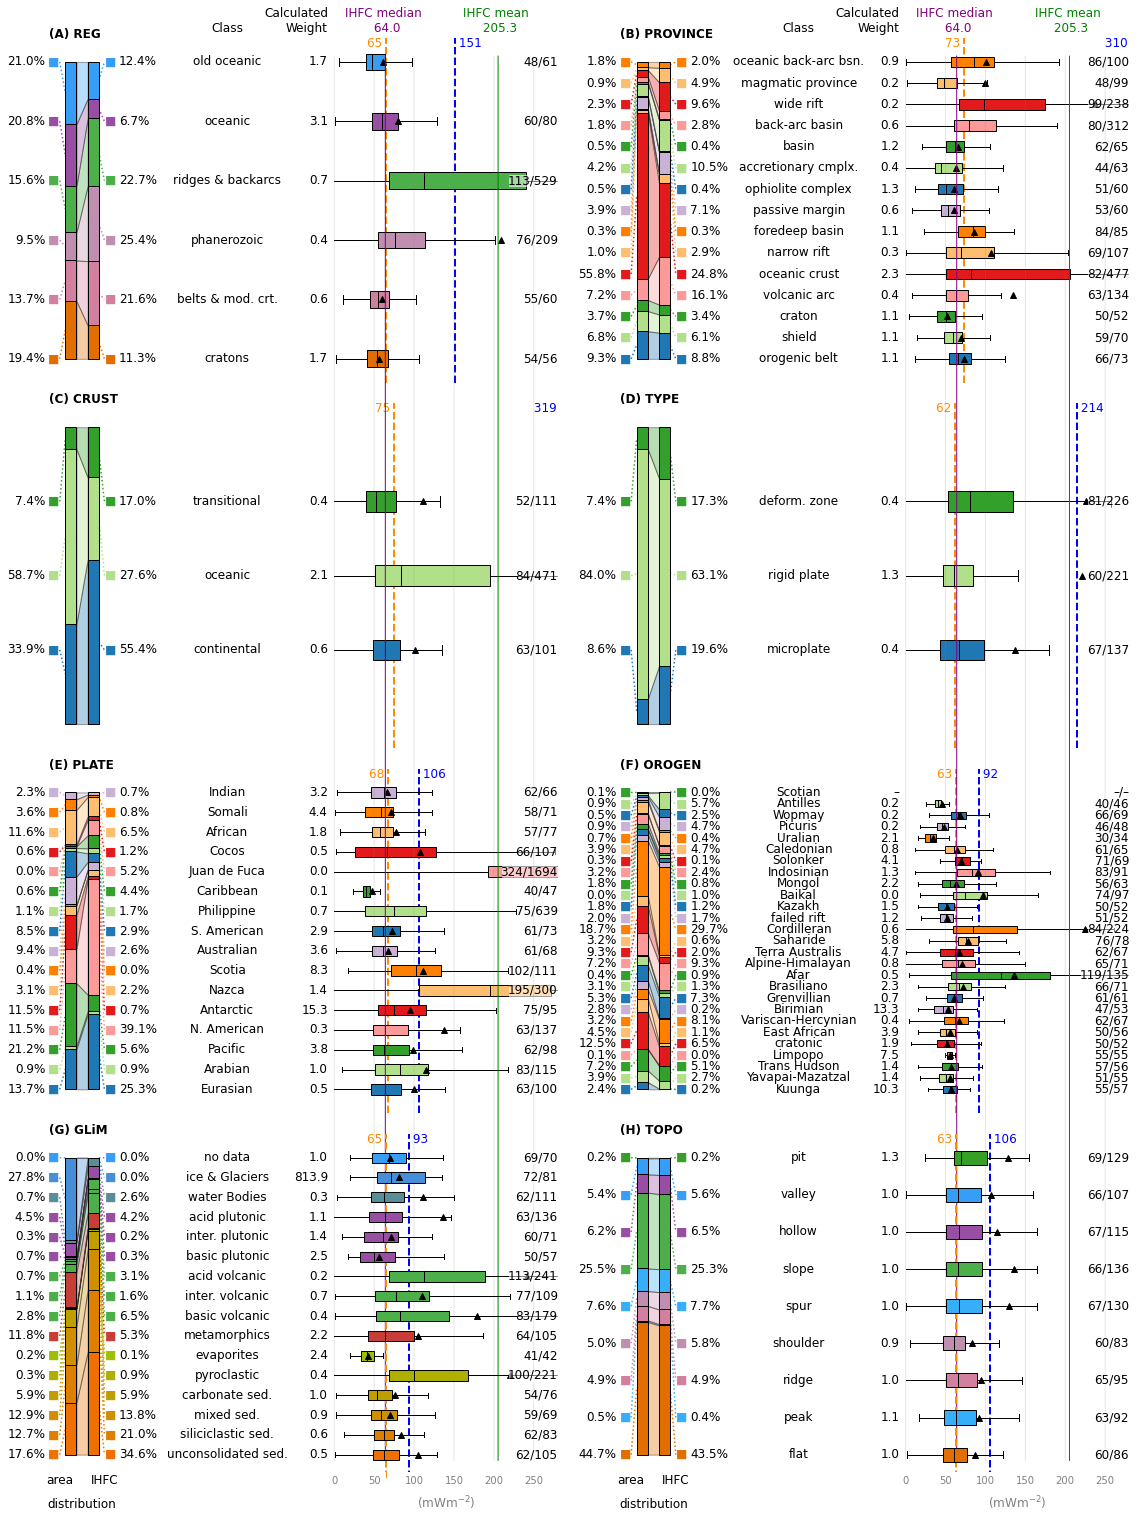

In [81]:
# Figure settings
ft = 0.39
fig_scale = 2.4

# Figure settings (left ax)
bar_width = 0.1

# Figure settings (right ax)
height_bar = 10
x_max = 280


fig, ax = plt.subplots(nrows = 4, ncols = 4, 
                       figsize = (17*ft*fig_scale, 22.5*ft*fig_scale),
                       sharey=True)


def super_v_line(x, 
                 col = 'gray', 
                 alpha=0.2, 
                 ax = ax):
    for x_ax in [1,3]:
        grid_line = matplotlib.patches.ConnectionPatch(xyA=(x, 1.02), 
                                                xyB=(x, -0.02), 
                                                coordsA=ax[0,x_ax].transData, 
                                                coordsB=ax[-1,x_ax].transData,
                                                color=col, 
                                                alpha = alpha, 
                                                zorder=1)
        ax[-1,x_ax].add_artist(grid_line)
    
        
# Make a grid and labels accross all subfigures
for gridline in np.arange(0, x_max, 50): 
    super_v_line(gridline)
    for x_ax in [-1, 1]:
        ax[-1, x_ax].text(gridline, -0.1, 
                          gridline, 
                          color = 'gray',
                          ha='center',
                          backgroundcolor='w')
        
for x_ax in [-1, 1]:       
    ax[-1, x_ax].text(x_max/2, -0.18, 
                          '(mWm$^{-2}$)', 
                          color = 'gray',
                      size = 12,
                          ha='center',
                          backgroundcolor='w')
    
    
# Lines and labels accross subfigures
super_v_line(ihfc_mean/milli, 'green', 1)
for x_ax in [-1, 1]: 
    ax[0, x_ax].text(ihfc_mean/milli, 1.1, 
                          'IHFC mean \n %.1f'%float(ihfc_mean/milli),
                          color = 'green',
                     size = 12,
                          ha='center')

super_v_line(ihfc_median/milli, 'purple', 1)
for x_ax in [-1, 1]: 
    ax[0, x_ax].text(ihfc_median/milli, 1.1, 
                          'IHFC median \n %.1f'%float(ihfc_median/milli),
                          color = 'purple',
                     size = 12,
                          ha='center')


    
# super_v_line(earth_mean/milli, 'green', 1)
# for x_ax in [-1, 1]: 
#     ax[0, x_ax].text(ihfc_median/milli, 1.1, 
#                           'Lucazeau (2019) \n %.1f'%float(earth_mean/milli),
#                           color = 'green',
#                           ha='center')
    
    


# Labels for columns, and definition of column spacing
ref_dist_x = 0.1
sample_dist_x = 0.5
label_x = 1.6
weight_x = 2.5


for i in [0, 2]:
    ax[-1,i].text(ref_dist_x, -0.1, 
                          'area',
                          color = 'k',
                          ha='center',
                size = 12)

    ax[-1,i].text(sample_dist_x, -0.1, 
                          'IHFC',
                          color = 'k',
                            size = 12,
                          ha='center')

    
    ax[-1,i].text((sample_dist_x + ref_dist_x)/2, -0.18, 
                          'distribution',
                          color = 'k',
                            size = 12,
                          ha='center')

    
    
    ax[0,i].text(label_x, 1.1, 
                          'Class',
                          color = 'k',
                             size = 12,
                          ha='center')
  
    ax[0,i].text(weight_x, 1.1, 
                          'Calculated\nWeight',
                          color = 'k',
                         size = 12,
                          ha='right')



# Make subfigures
# select order of rows
fig_obs = obs.iloc[[0,1,2,3,4,5,6,7]]

# Exclude last two rows
for i, d in obs_sort.iloc[:-2].iterrows():
    
    #label = d['title']
    
    # Set subfig index and show title
    a0 = ax[i//2,2*i%4]
    a1 = ax[i//2,2*i%4+1]
    
    
    a0.text(0, 1, '(%s) %s'%(d['subfig'], d['title']),
        transform=a0.transAxes, 
        fontsize = 'large', 
        ha = 'left',
        va = 'baseline',
        fontweight = 'bold')
        
    a0.axis('off')
    a1.axis('off')

    a0.set_xlim(0, 2)
    a0.set_ylim(-0.08, 1.08)
    
    a1.set_xlim(-0.01, x_max)
    a1.set_ylim(-0.08, 1.08)
    
    q_mean_u = np.zeros(len(d['order']))
    q_median_u = np.zeros(len(d['order']))

    bottom_count = 0
    bottom_sample = 0
    
    for i, (u, weight, col, label_text, label_y) in enumerate(zip(
         d['order'], 
         d['weights'], 
         d['colors'], 
         d['labels'],
         np.linspace(0, 1, len(d['order']), endpoint=True))
     ):

        
        # centre the labels if only a few classes
        if len(d['order']) < 5:
             label_y = 0.25 + label_y / 2
        
        r_y = d['r_percent'][u]/100
        s_y = d['s_percent'][u]/100
        

        # Make bars for area
        a0.text(0.1, label_y, u"\u25A0",
                 c=col, 
                 ha = 'right', 
                 va='center', 
                 size = 12)
    
        a0.text(-0.03, label_y, '%.1f%%'%(d['r_percent'][u]),
                 c='k', 
                ha = 'right', 
                va='center', 
                size = 12)
    
    
        a0.plot([0.1, 0.2-bar_width/2],
                [label_y, bottom_count + r_y/2], 
                linestyle = ':',
                c=col) 

        a0.bar([0.2],  r_y, 
                bottom = bottom_count, 
                width = bar_width, 
                edgecolor = 'k',
                label = u, 
                color = col, 
                zorder = 100)
    
        a0.fill_between([0.2+bar_width/2, 0.4-bar_width/2], 
                         [bottom_count, bottom_sample], 
                        [bottom_count+r_y, 
                         bottom_sample+s_y], 
                         facecolor=col, 
                         edgecolor = 'k', 
                         alpha = 0.35,
                        interpolate=True)
 
        a0.bar([0.4], s_y, 
               bottom = bottom_sample,
               width = bar_width, 
               edgecolor = 'k',
               color = col, 
               zorder = 100)


        a0.plot([0.4+bar_width/2, 0.5],
                [bottom_sample + s_y/2, label_y], 
                linestyle = ':',
                c=col) 

  
        # Make bars for heatflow samples
        a0.text(0.5, label_y, u"\u25A0",
                c=col, ha = 'left', va='center', size = 12)
        
        a0.text(0.63, label_y, '%.1f%%'%d['s_percent'][u],
                c='k', ha = 'left', va='center', size = 12)

        a0.text(label_x, label_y, '%s'%(label_text),
                c='k', ha = 'center', va='center', size = 12)
        
    
        # Set under level for next bar block
        bottom_count += r_y
        bottom_sample += s_y
     
    
        if np.isfinite(weight):
            weight_str = '%.1f'%weight
        else:
            weight_str = '–'
            
        a0.text(weight_x, label_y, 
                weight_str, 
                c = 'k',
                ha = 'right', 
                va='center', 
                size = 12)
        
            
        # Heat flow distribution for each class
        height_bar = 0.9/(len(d['order'])+10)
        a1.boxplot(gdf.loc[gdf[d['attribute']] == u, 'q']/milli, 
                    vert= False, 
                    positions=[label_y], 
                    showfliers=False, 
                    patch_artist=True,
                    boxprops=dict(facecolor=col, color='k'),
                    showmeans=True,
                    meanprops = dict(markerfacecolor='k', markeredgecolor ='k'),
                    medianprops = dict(color='k'), 
                    widths=height_bar,
                    zorder=10)
      


    
        q_mean_u[i] = np.nanmean(gdf.loc[gdf[d['attribute']] == u, 'q'])
        q_median_u[i] = np.nanmedian(gdf.loc[gdf[d['attribute']] == u, 'q'])
        
        # Print mean and median values (for debugging)
        if np.isfinite(q_mean_u[i]):
            mean_str = '%.0f/%.0f'%(q_median_u[i]/milli, q_mean_u[i]/milli)
        else:
            mean_str = '–/–'
        q_text = a1.text(x_max, label_y, 
                mean_str, 
                ha = 'right', 
                va='center', 
                size = 12, 
               zorder = 200)
        q_text.set_bbox(dict(facecolor='white', 
                             boxstyle='square,pad=-0.1',
                             alpha=0.5, 
                             edgecolor='white'))
        

    
    # The total area (in 'units') for the classes included
    area_weights = [d['reference_n'][o] for o in d['order']]
    area_weights /= np.sum(area_weights)

        
    mask_nan = np.where(np.logical_not(np.isnan(q_mean_u)))[0]
    q_sampled_mean = np.average(q_mean_u[mask_nan], weights=area_weights[mask_nan])
    q_sampled_median = np.average(q_median_u[mask_nan], weights=area_weights[mask_nan])


    a1.axvline(x = q_sampled_mean/milli, c = 'blue', zorder = 1, linestyle='dashed', lw = 2)
    a1.axvline(x = q_sampled_median/milli, c = 'darkorange', zorder = 1,linestyle='dashed', lw=2)
    
    a1.text(np.clip(q_sampled_mean/milli, 0, x_max-35), 1.05, ' %.0f'%(q_sampled_mean/milli),  
            c = 'blue', 
            size = 12, 
            zorder = 200, 
            ha = 'left')
    a1.text(np.clip(q_sampled_median/milli, 0, x_max-35), 1.05, '%.0f '%(q_sampled_median/milli),  
            c = 'darkorange', 
            size = 12, 
            zorder = 200, 
            ha = 'right')
    
    
    a0.margins(0,0)
    a1.margins(0,0)


#fig.subplots_adjust(wspace=0.5, hspace=0.05)
fig.tight_layout()
fig.savefig('fig/fig_2.png', dpi=300)


In [82]:
! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

building file list ... 
15 files to consider
fig/fig_2.png
       2.25M 100%  302.52MB/s    0:00:00 (xfer#1, to-check=11/15)

sent 2.25M bytes  received 42 bytes  4.51M bytes/sec
total size is 49.98M  speedup is 22.17


In [83]:
aus_mask = gdf['A_reg'] == 'Australia'

mines_mask =  gdf['mine'] == 'mine'
oil_mask =  gdf['oil_gas'] == 'oil_gas'
both_mask = mines_mask * oil_mask
no_mask = ~mines_mask * ~oil_mask

area_aus_mining = 1_657_682_941_538.792/km/km
area_aus_oil = 392_591_519_548.138/km/km
area_aus_both = 35_836_647_311.976/km/km
area_australia = 7_692_024


area_glob_mining = 17327719234954.088/km/km
area_glob_oil =    11967071326640.859/km/km
area_glob_both =    1027279009144.047/km/km
area_glob = 148_940_000




n_glob = len(gdf)
n_glob_mines =  mines_mask.sum()
n_glob_oil = oil_mask.sum()

print('IHFC Global:', n_glob_mines/n_glob, n_glob_oil/n_glob)
print('Area Global:', area_glob_mining/area_glob, area_glob_oil/area_glob)


n_glob_both = (oil_mask*mines_mask).sum()
n_glob_oil = n_glob_oil - n_glob_both
n_glob_mines = n_glob_mines- n_glob_both
n_glob_none = no_mask.sum()

n_aus = aus_mask.sum()
n_aus_mines = (aus_mask*mines_mask).sum()
n_aus_oil = (aus_mask*oil_mask).sum()
n_aus_none = (aus_mask*no_mask).sum()


print('IHFC Australia:', n_aus_mines/n_aus, n_aus_oil/n_aus)
print('Area Australa:', area_aus_mining/area_australia, area_aus_oil/area_australia)

n_aus_both = (aus_mask*oil_mask*mines_mask).sum()
n_aus_oil = n_aus_oil - n_aus_both
n_aus_mines = n_aus_mines- n_aus_both
n_aus_none = (no_mask*aus_mask).sum()



cultural_bar =[
    {'title' : 'mining region',
    'n_aus': n_aus_mines,
    'area_aus' : area_aus_mining, 
    'n_glob': n_glob_mines,
    'area_glob' : area_glob_mining, 
    'color' : 'gray'},
    
    {'title' : 'oil and gas field',
     'area_aus' : area_aus_oil, 
     'color' : 'brown',
    'n_glob': n_glob_oil,
    'area_glob' : area_glob_oil, 
    'n_aus' : n_aus_oil},
    
    {'title' : 'both',
     'color' : 'red',
     'area_aus' : area_aus_both, 
    'n_aus' : n_aus_both,
        'n_glob': n_glob_both,
    'area_glob' : area_glob_both, },
    
    {'title': 'neither',
     'color' : 'green',
     'area_aus' : area_australia - area_aus_oil - area_aus_mining + area_aus_both,
    'n_glob': n_glob_none,
    'area_glob' :  area_glob - area_glob_oil - area_glob_mining + area_glob_both,
    'n_aus': n_aus_none}
]


IHFC Global: 0.07283728668026189 0.17777986476333585
Area Global: 0.11634026611356309 0.08034826995193271
IHFC Australia: 0.2615803814713896 0.38283378746594005
Area Australa: 0.21550673028825598 0.05103877985145886


In [84]:
mine_poly = list(shpreader.Reader(mines['file']).geometries())
oil_poly = list(shpreader.Reader(oil_fields['file']).geometries())

building file list ... 
15 files to consider
fig/fig_3.png
     896.62K 100%  274.61MB/s    0:00:00 (xfer#1, to-check=10/15)

sent 897.20K bytes  received 42 bytes  1.79M bytes/sec
total size is 49.98M  speedup is 55.70


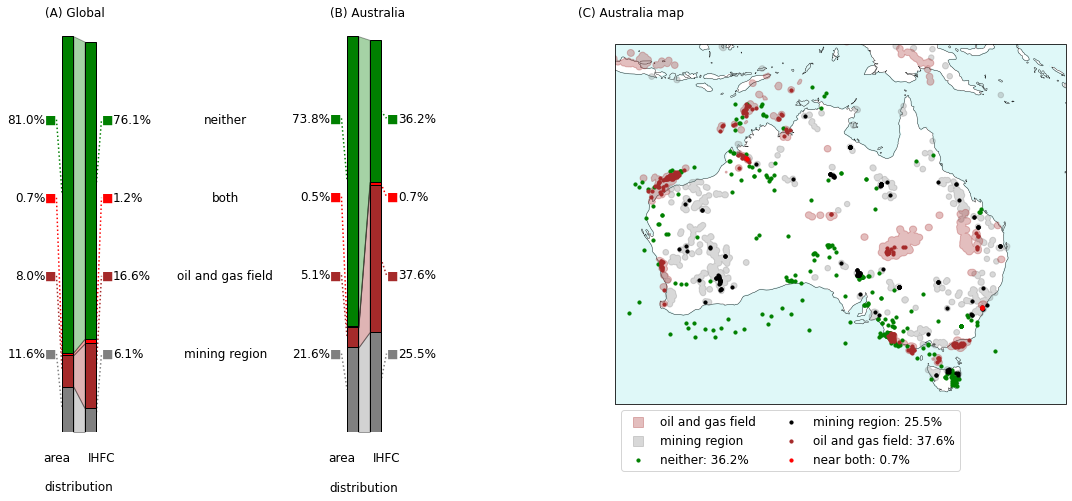

In [85]:

fig = plt.figure(figsize = (15,7))

gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2]) 


a0 = fig.add_subplot(gs[0])
a1 = fig.add_subplot(gs[1])
a2 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
#ax0.set_extent([-20, 60, -40, 45], crs=ccrs.PlateCarree())
a2.set_extent([110, 160, -45, -5], crs=ccrs.PlateCarree())


a2.add_feature(cartopy.feature.COASTLINE, lw = 0.4)
a2.add_feature(cartopy.feature.OCEAN.with_scale('110m'), facecolor='paleturquoise',alpha=0.4)


a2.add_geometries(mine_poly, ccrs.PlateCarree(),
             edgecolor='gray', facecolor='gray', alpha=0.3)
a2.add_geometries(oil_poly, ccrs.PlateCarree(),
             edgecolor='brown', facecolor='brown', alpha=0.3)


a2.scatter([0], [0], transform = ccrs.PlateCarree(), 
           c = 'brown',
           marker = 's', 
           alpha=0.3, 
           s = 100, 
           label = 'oil and gas field')


a2.scatter([0], [0], transform = ccrs.PlateCarree(), 
           c = 'gray',
           marker = 's', 
           alpha=0.3, 
           s = 100, 
           label = 'mining region')


# ax.scatter(ix[aus_mask*mines_mask], iy[mask*mines_mask], 
#             transform = ccrs.PlateCarree(),c='k', s = 10, zorder = 200)

a2.scatter(ix[aus_mask*no_mask], iy[aus_mask*no_mask], 
            transform = ccrs.PlateCarree(), c='green', s = 10, zorder = 200, 
           label = 'neither: %.1f%%'% (100*n_aus_none/n_aus))


a2.scatter(ix[aus_mask*mines_mask], iy[aus_mask*mines_mask], 
            transform = ccrs.PlateCarree(), c='k', s = 10, zorder = 200, 
          label = 'mining region: %.1f%%'% (100*n_aus_mines/n_aus))

a2.scatter(ix[aus_mask*oil_mask], iy[aus_mask*oil_mask], 
            transform = ccrs.PlateCarree(), c='brown', s = 10, zorder = 200,
           label = 'oil and gas field: %.1f%%'% (100*n_aus_oil/n_aus))

a2.scatter(ix[aus_mask*both_mask], iy[aus_mask*both_mask], 
            transform = ccrs.PlateCarree(), c='red', s = 10, zorder = 200, 
           label = 'near both: %.1f%%'% (100*n_aus_both/n_aus))




a2.legend(loc='center left', bbox_to_anchor=(0, -0.1), ncol=2, prop={'size': 12})


bottom_count_aus = 0
bottom_sample_aus = 0
bottom_count_glob = 0
bottom_sample_glob = 0


for i, (c, label_y) in enumerate(zip(cultural_bar, [0.2, 0.4, 0.6, 0.8])):
        r_y = c['area_aus']/area_australia
        s_y = c['n_aus']/n_aus

        col = c['color']
        
         # Make bars for area
        a1.text(0.1, label_y, u"\u25A0",
                 c=col, 
                 ha = 'right', 
                 va='center', 
                 size = 12)
    
        a1.text(0.0, label_y, '%.1f%%'%(r_y*100),
                 c='k', 
                ha = 'right', 
                va='center', 
                size = 12)
    
    
        a1.plot([0.1, 0.2-bar_width/2],
                [label_y, bottom_count_aus + r_y/2], 
                linestyle = ':',
                c=col) 

        a1.bar([0.2],  r_y, 
                bottom = bottom_count_aus, 
                width = bar_width, 
                edgecolor = 'k',
                label = u, 
                color = col, 
                zorder = 100)
    
        a1.fill_between([0.2+bar_width/2, 0.4-bar_width/2], 
                         [bottom_count_aus, bottom_sample_aus], 
                        [bottom_count_aus+r_y, 
                         bottom_sample_aus+s_y], 
                         facecolor=col, 
                         edgecolor = 'k', 
                         alpha = 0.35,
                        interpolate=True)
 
        a1.bar([0.4], s_y, 
               bottom = bottom_sample_aus,
               width = bar_width, 
               edgecolor = 'k',
               color = col, 
               zorder = 100)


        a1.plot([0.4+bar_width/2, 0.5],
                [bottom_sample_aus + s_y/2, label_y], 
                linestyle = ':',
                c=col) 

  
        # Make bars for heatflow samples
        a1.text(0.5, label_y, u"\u25A0",
                c=col, ha = 'left', 
                va='center', size = 12)
        
        a1.text(0.6, label_y, '%.1f%%'%(s_y*100),
                 c='k', ha = 'left', va='center', size = 12)

    
        # Set under level for next bar block
        bottom_count_aus += r_y
        bottom_sample_aus += s_y
    

        r_y = c['area_glob']/area_glob
        s_y = c['n_glob']/n_glob

        col = c['color']
        
         # Make bars for area
        a0.text(0.1, label_y, u"\u25A0",
                 c=col, 
                 ha = 'right', 
                 va='center', 
                 size = 12)
    
        a0.text(0.0, label_y, '%.1f%%'%(r_y*100),
                 c='k', 
                ha = 'right', 
                va='center', 
                size = 12)
    
    
        a0.plot([0.1, 0.2-bar_width/2],
                [label_y, bottom_count_glob + r_y/2], 
                linestyle = ':',
                c=col) 

        a0.bar([0.2],  r_y, 
                bottom = bottom_count_glob, 
                width = bar_width, 
                edgecolor = 'k',
                label = u, 
                color = col, 
                zorder = 100)
    
        a0.fill_between([0.2+bar_width/2, 0.4-bar_width/2], 
                         [bottom_count_glob, bottom_sample_glob], 
                        [bottom_count_glob+r_y, 
                         bottom_sample_glob+s_y], 
                         facecolor=col, 
                         edgecolor = 'k', 
                         alpha = 0.35,
                        interpolate=True)
 
        a0.bar([0.4], s_y, 
               bottom = bottom_sample_glob,
               width = bar_width, 
               edgecolor = 'k',
               color = col, 
               zorder = 100)


        a0.plot([0.4+bar_width/2, 0.5],
                [bottom_sample_glob + s_y/2, label_y], 
                linestyle = ':',
                c=col) 

  
        # Make bars for heatflow samples
        a0.text(0.5, label_y, u"\u25A0",
                c=col, ha = 'left', 
                va='center', size = 12)
        
        a0.text(0.6, label_y, '%.1f%%'%(s_y*100),
                 c='k', ha = 'left', va='center', size = 12)

        a0.text(label_x, label_y, '%s'%(c['title']),
                c='k', ha = 'center', va='center', size = 12)
        
    
        # Set under level for next bar block
        bottom_count_glob += r_y
        bottom_sample_glob += s_y
    
    
    
    
a0.text(0, 1,  '(A) Global', ha='left', size = 'large',transform=a0.transAxes)
a1.text(0, 1,  '(B) Australia', ha='left', size = 'large', transform=a1.transAxes)
a2.text(1.1, 1,  '(C) Australia map', ha='left', size = 'large', transform=a1.transAxes)
 
    
for a in [a0, a1]:
    a.text(0.1, -0.075, 
                          'area',
                          color = 'k',
                          ha='center',
                size = 12)

    a.text(0.5, -0.075, 
                          'IHFC',
                          color = 'k',
                            size = 12,
                          ha='center')

    
    a.text(0.3, -0.15, 
                          'distribution',
                          color = 'k',
                            size = 12,
                          ha='center')

    
    
    
    
for a in [a0, a1]:
    a.axis('off')
    a.set_xlim(0,2)
    
fig.tight_layout()
fig.savefig('fig/fig_3.png', dpi=300)

! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

In [86]:
used_weights = [ 'prov_type',
 'lastorogen',
 'crust_type',
 'plate_type',
 'plate',
 'REG',
 'GLiM',
 'TOPO']

def get_label(attr):
    return obs_sort.loc[obs_sort['attribute'] == attr, 'title'].values[0]


In [87]:
def get_variables(label):
    '''
    Generate margianl distribution
    class
    tables
    and return label
    '''
    row = obs.loc[obs['attribute'] == label]
    aggregate = np.array([row['r_percent'].values[0][k] for k in row['order'].values[0]])
    return aggregate, np.array(list(row['order'].values[0])), gdf[label].values, label


def weighted_median(data, weights):
    data, weights = np.array(data).flatten(), np.array(weights).flatten()
    if any(weights > 0):
        sorted_data, sorted_weights = map(np.array, zip(*sorted(zip(data, weights))))
        midpoint = 0.5 * sum(sorted_weights)
        if any(weights > midpoint):
            return (data[weights == np.max(weights)])[0]
        cumulative_weight = np.cumsum(sorted_weights)
        below_midpoint_index = np.where(cumulative_weight <= midpoint)[0][-1]
        if np.abs(cumulative_weight[below_midpoint_index] - midpoint) < sys.float_info.epsilon:
            return np.mean(sorted_data[below_midpoint_index:below_midpoint_index+2])
        return sorted_data[below_midpoint_index+1]



def get_ipfn_2(label_1, label_2, convergence_rate=1e-6, w_label = None):
    if w_label is None:
        w_label = 'w_' + get_label(label_1) +  '_' + get_label(label_2)
    
    
    m1, c1, tab1, lab1 = get_variables(label_1)
    m2, c2, tab2, lab2 = get_variables(label_2)
    
    c1 = c1[:, None, None]
    c2 = c2[None,:, None]
    
    vector_seed = np.sum((c1 == tab1[None,None, :]) * 
                      (c2 == tab2[None,None,:]), axis=-1)
    vector_seed = np.divide(vector_seed, len(gdf))

    aggregates = [m1, m2]
    dimensions = [[0], [1]]
    
    
    IPF = ipfn.ipfn(vector_seed, 
                    aggregates, 
                    dimensions, 
                    verbose = 1,
                    convergence_rate=convergence_rate)
    mf2, flag  = IPF.iteration()
    

    gdf[w_label] = 1
    for i, n1 in enumerate(c1.flatten()):
        for j, n2 in enumerate(c2.flatten()):
            mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)
            gdf.loc[mask, w_label] = mf2[i,j]
    return np.average(gdf['q'], weights=gdf[w_label]), weighted_median(gdf['q'], weights=gdf[w_label]), flag




def get_ipfn_3(label_1, label_2, label_3, convergence_rate=1e-6, w_label = None):
    if w_label is None:
        w_label = 'w_' + get_label(label_1) +  '_' + get_label(label_2) +  '_' + get_label(label_3)
        
        
    m1, c1, tab1, lab1 = get_variables(label_1)
    m2, c2, tab2, lab2 = get_variables(label_2)
    m3, c3, tab3, lab3 = get_variables(label_3)


    # # # Assign dim to each variable + extra dim at end
    c1 = c1[:, None, None, None]
    c2 = c2[None,:, None, None]
    c3 = c3[None, None, :, None]


    # Place data in the last dim
    vector_seed = np.sum((c1 == tab1[None,None,None, :]) * 
                          (c2 == tab2[None, None,None,:]) *
                          (c3 == tab3[None, None,None,:]), axis=-1)

    vector_seed = np.divide(vector_seed, len(gdf))


    aggregates = [m1, m2, m3]
    dimensions = [[0], [1], [2]]

    IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, 
                    verbose = 1,
                    convergence_rate=1e-6)
    mf3, flag = IPF.iteration()


    gdf[w_label] = 1
    for i, n1 in enumerate(c1.flatten()):
        for j, n2 in enumerate(c2.flatten()):
            for k, n3 in enumerate(c3.flatten()):
                mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)* (gdf[lab3]==n3)
                gdf.loc[mask, w_label] = mf3[i,j, k]
                
    return np.average(gdf['q'], weights=gdf[w_label]), weighted_median(gdf['q'], weights=gdf[w_label]), flag



    





def get_ipfn_4(label_1, label_2, label_3, label_4, convergence_rate=1e-6, w_label = None):
    if w_label is None:
        w_label = 'w_' + get_label(label_1) +  '_' + get_label(label_2) +  '_' + get_label(label_3) +  '_' + get_label(label_4)
        
        
    m1, c1, tab1, lab1 = get_variables(label_1)
    m2, c2, tab2, lab2 = get_variables(label_2)
    m3, c3, tab3, lab3 = get_variables(label_3)
    m4, c4, tab4, lab4 = get_variables(label_4)


    # # # Assign dim to each variable + extra dim at end
    c1 = c1[:, None, None, None, None]
    c2 = c2[None,:, None, None, None]
    c3 = c3[None, None, :, None, None]
    c4 = c4[None, None, None, :, None]


    # Place data in the last dim
    vector_seed = np.sum((c1 == tab1[None,None,None,None, :]) * 
                          (c2 == tab2[None, None,None,None,:]) *
                          (c3 == tab3[None, None,None,None,:]) *
                         (c4 == tab4[None, None,None,None,:]), axis=-1)

    vector_seed = np.divide(vector_seed, len(gdf))


    aggregates = [m1, m2, m3, m4]
    dimensions = [[0], [1], [2], [3]]

    IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, 
                    verbose = 1,
                    convergence_rate=1e-6)
    mf4, flag = IPF.iteration()

    gdf[w_label] = 1
    for i, n1 in enumerate(c1.flatten()):
        for j, n2 in enumerate(c2.flatten()):
            for k, n3 in enumerate(c3.flatten()):
                for l, n4 in enumerate(c4.flatten()):
                    mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)* (gdf[lab3]==n3)* (gdf[lab4]==n4)
                    gdf.loc[mask, w_label] = mf4[i,j, k, l]
                    
    return np.average(gdf['q'], weights=gdf[w_label]), weighted_median(gdf['q'], weights=gdf[w_label]), flag




                
                




In [92]:



comb_2 = list(combinations(used_weights, 2))

w_results_2 = []

    
for label_1, label_2 in comb_2:
    w_mean, w_median, flag = get_ipfn_2(label_1, label_2)
    print(label_1, label_2, '->',w_mean, w_median, flag)
    w_results_2.append({'label_1': get_label(label_1), 'label_2': get_label(label_2),
                        'label_3': ' ', 'label_4': ' ', 
                       'flag': flag, 'q_mean' : w_mean/milli, 'q_median' : w_median/milli})


ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type lastorogen -> 0.17898016644364148 0.064 1
prov_type crust_type -> 0.41978910808866277 0.075 1
prov_type plate_type -> 0.43324068923834286 0.07 1
prov_type plate -> 0.11375608962158558 0.062 1
prov_type REG -> 0.35732063834447714 0.068 1
ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type GLiM -> 0.3018053139319085 0.067 1
prov_type TOPO -> 0.1755059967090879 0.063 1
ipfn converged: convergence_rate not updating or below rate_tolerance
lastorogen crust_type -> 0.3026408539207099 0.0584 1
ipfn converged: convergence_rate not updating or below rate_tolerance
lastorogen plate_type -> 0.14744040647842485 0.062 1
ipfn converged: convergence_rate not updating or below rate_tolerance
lastorogen plate -> 0.17415847750796223 0.066 1
ipfn converged: convergence_rate not updating or below rate_tolerance
lastorogen REG -> 0.18023320857052563 0.066 1
ipfn converged: convergence_rate not updati

114.71949900570083
     label_1 label_2 label_3 label_4  flag      q_mean  q_median        Diff
0       TYPE    TOPO                     1   84.053151      58.0    3.672342
1       TYPE   PLATE                     1   95.268311      59.0   14.887502
2       TYPE    GLiM                     1   96.621997      58.2   16.241188
3      PLATE     REG                     1  105.460117      59.0   25.079308
4      CRUST   PLATE                     1  107.959215      62.8   27.578406
5   PROVINCE   PLATE                     1  113.756090      62.0   33.375281
6      CRUST    TOPO                     1  115.534923      62.0   35.154114
7        REG    TOPO                     1  127.452895      60.0   47.072086
8       GLiM    TOPO                     1  136.320391      61.0   55.939582
9      PLATE    TOPO                     1  138.999979      62.0   58.619170
10    OROGEN    TYPE                     1  147.440406      62.0   67.059597
11       REG    GLiM                     1  147.627893   

/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/1620803816.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab_2.to_latex(buf = 'tex/tab_2.tex', float_format="%.2f")


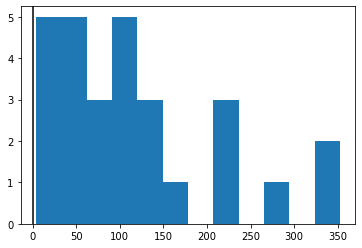

In [93]:
tab_2 = pd.DataFrame.from_dict(w_results_2)
tab_2['Diff'] = np.abs(earth_mean/milli-tab_2['q_mean'])

tab_2 = tab_2.sort_values(['flag', 'Diff'], ascending = [False, True]).reset_index(drop=True)
tab_2.to_latex(buf = 'tex/tab_2.tex', float_format="%.2f")
print(tab_2['Diff'].mean())
print(tab_2)



fig, ax = plt.subplots(1,1)
ax.hist(tab_2['Diff'], bins = 12)

ax.axvline(x=ihfc_mean -earth_mean, c = 'k')


In [94]:
comb_3 = list(combinations(used_weights, 3))
w_results_3 = []


for label_1, label_2, label_3 in list(combinations(used_weights, 3)):
    w_mean, w_median, flag = get_ipfn_3(label_1, label_2, label_3)
    print(label_1, label_2, label_3,'->',w_mean, w_median, flag)
    
    w_results_3.append({'label_1': get_label(label_1), 'label_2': get_label(label_2),
                        'label_3': get_label(label_3), 'label_4': ' ', 
                       'flag': flag, 'q_mean' : w_mean/milli, 'q_median' : w_median/milli})

ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type lastorogen crust_type -> 0.4172906461467412 0.06 1
ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type lastorogen plate_type -> 0.16750462517546363 0.059000000000000004 1
Maximum iterations reached
prov_type lastorogen plate -> 0.29281609914506956 0.068 0
ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type lastorogen REG -> 0.2171995610229279 0.062 1
ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type lastorogen GLiM -> 0.2416031575204018 0.065 1
ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type lastorogen TOPO -> 0.226147527848846 0.063 1
prov_type crust_type plate_type -> 0.4532796001299434 0.073 1
prov_type crust_type plate -> 0.11494273100674557 0.062 1
prov_type crust_type REG -> 0.3708229797730324 0.07 1
ipfn converged: convergence_rate not updating or below rate_tolerance
prov_type crust_

143.4983626161357
     label_1 label_2 label_3 label_4  flag      q_mean  q_median        Diff
0      CRUST    TYPE   PLATE             1   93.420788      60.0   13.039979
1       TYPE   PLATE     REG             1   95.948842      58.0   15.568033
2      CRUST   PLATE     REG             1  102.949381      59.0   22.568572
3      CRUST    TYPE    TOPO             1  107.305593      58.3   26.924784
4   PROVINCE    TYPE   PLATE             1  107.437781      60.0   27.056972
5   PROVINCE   CRUST   PLATE             1  114.942731      62.0   34.561922
6   PROVINCE   PLATE     REG             1  124.934546      62.0   44.553737
7       TYPE     REG    TOPO             1  126.161311      58.0   45.780502
8       TYPE   PLATE    TOPO             1  137.837728      59.0   57.456919
9       TYPE    GLiM    TOPO             1  145.232859      59.0   64.852050
10      TYPE     REG    GLiM             1  150.195463      59.0   69.814654
11     CRUST     REG    TOPO             1  158.965816    

/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/2695473331.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab_3.to_latex(buf = 'tex/tab_3.tex',  float_format="%.2f")


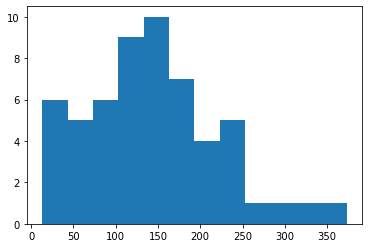

In [96]:
tab_3 = pd.DataFrame.from_dict(w_results_3)
tab_3['Diff'] = np.abs(earth_mean/milli-tab_3['q_mean'])

tab_3 = tab_3.sort_values(['flag', 'Diff'], ascending = [False, True]).reset_index(drop=True)
tab_3.to_latex(buf = 'tex/tab_3.tex',  float_format="%.2f")
print(tab_3['Diff'].mean())
print(tab_3)




plt.hist(tab_3['Diff'], bins = 12);

In [ ]:
%%time 

comb_4 = list(combinations(used_weights, 4))
w_results_4 = []
    
# for label_1, label_2, label_3, label_4 in comb_4:
#     w_mean, w_median, flag = get_ipfn_4(label_1, label_2, label_3, label_4)
#     print(label_1, label_2, label_3, label_4, '->',w_mean, w_median, flag)
#     w_results_4.append({'label_1': get_label(label_1), 'label_2': get_label(label_2),
#                         'label_3': get_label(label_3), 'label_4': get_label(label_4), 
#                        'flag': flag, 'q_mean' : w_mean/milli, 'q_median' : w_median/milli})


In [ ]:
# tab_4 = pd.DataFrame.from_dict(w_results_4)
# tab_4['Diff'] = np.abs(earth_mean/milli-tab_4['q_mean'])

# tab_4 = tab_4.sort_values(['flag', 'Diff'], ascending = [False, True]).reset_index(drop=True)


# tab_4[:50].to_latex(buf = 'tex/tab_4a.tex',  float_format="%.2f")
# tab_4[50:].to_latex(buf = 'tex/tab_4b.tex',  float_format="%.2f")
# print(tab_4['Diff'].mean())
# print(tab_4)




# plt.hist(tab_4['Diff'], bins = 12);

In [97]:
! rsync -avhP /Users/tobias_stal/proj/topo_heat/tex /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

building file list ... 
8 files to consider
tex/tab_2.tex
       2.60K 100%    0.00kB/s    0:00:00 (xfer#1, to-check=5/8)
tex/tab_3.tex
       5.04K 100%    4.80MB/s    0:00:00 (xfer#2, to-check=4/8)

sent 7.93K bytes  received 64 bytes  15.99K bytes/sec
total size is 31.96K  speedup is 4.00


In [ ]:
# How many are closer to Lucazeay than IHFC meaan? 

# Highest and lowest weight

# Title to weight calculations

In [ ]:
! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

w_REG
1.1391785262121494
w_TOPO
0.24797126348779241
w_prov_type
1.6600603803686267
w_GLiM
6.701798787999737
w_TYPE_TOPO
4.29251900488126
w_CRUST_TYPE_PLATE
6.7114394110096915
w_CRUST_TYPE_GLiM
54.096139334810886
w_TYPE_GLiM_TOPO
8.249620448432351


/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_83463/3243463777.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


building file list ... 
15 files to consider
fig/fig_4.png
       7.83M 100%  309.76MB/s    0:00:00 (xfer#1, to-check=9/15)

sent 7.83M bytes  received 42 bytes  15.66M bytes/sec
total size is 49.60M  speedup is 6.33


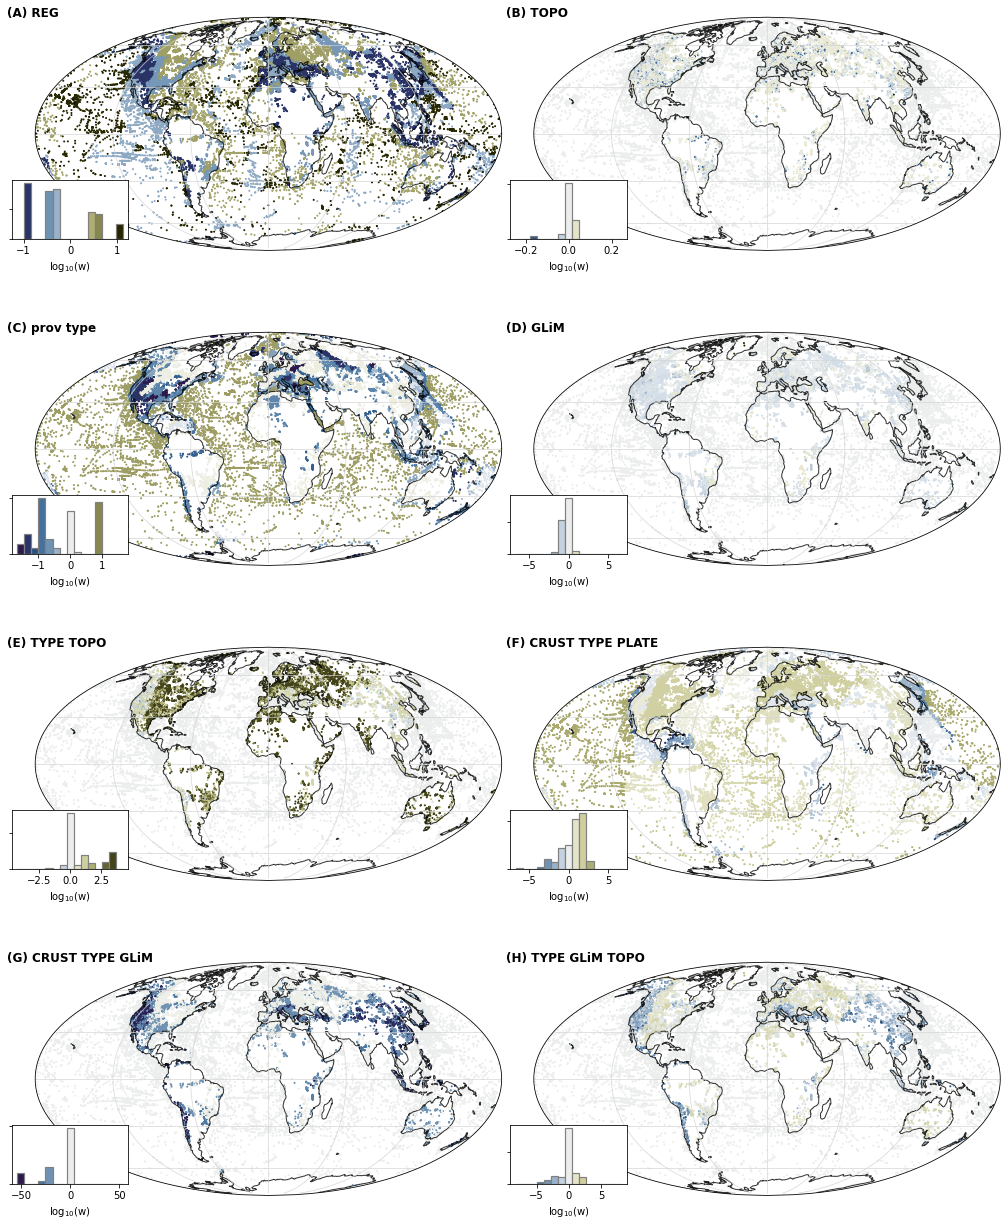

In [100]:
fig, ax = plt.subplots(4,2, 
                       figsize = (14,18),
                       subplot_kw = {'projection' : ccrs.Mollweide()})


def plot_weights(w_data, weight_label, a):
    v_extreme = np.max([np.max(w_data), -np.min(w_data)])
    
    if not np.isfinite(v_extreme):
        v_extreme = 1.

    
    a.scatter(gdf['lng'], 
              gdf['lat'], 
                s = 1,
                vmin = -v_extreme,
              vmax = v_extreme,
                cmap = SCM6.broc,
                c = w_data, 
                transform = ccrs.PlateCarree())


    axins = inset_axes(a, width="100%", height="100%",
                   bbox_to_anchor=(-.05, 0.05, .25, .25),
                   bbox_transform=a.transAxes, borderpad=0)
    
    print(v_extreme)
    
    n, bins, patches = axins.hist(w_data, 
                                  bins = 15, 
                                  range = (-v_extreme, v_extreme), 
                                  edgecolor='gray', linewidth=1.2)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    cm = plt.cm.get_cmap(SCM6.broc)
    col = (bin_centers - np.min(bin_centers))/np.ptp(bin_centers)
    
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    
    
    axins.tick_params(labelleft=False)
    axins.set_xlabel('log$_{10}$(w)')
    axins.set_xlim(-v_extreme*1.1, v_extreme*1.1)
    
    


for i, w in enumerate(['w_REG', 'w_TOPO', 'w_prov_type', 'w_GLiM', 
                       'w_TYPE_TOPO', 'w_CRUST_TYPE_PLATE', 
                       'w_CRUST_TYPE_GLiM', 'w_TYPE_GLiM_TOPO']):
    
    a = ax.flatten()[i]
    
    w_data = np.log(gdf[w].values)
    
    print(w)
    plot_weights(w_data, w, a)
    
    a.text(-0.06, 1, '(%s) %s'%('ABCDEFGHI'[i], w[2:].replace('_', ' ')),
           transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.set_global()
    a.coastlines(resolution='auto', color='k', alpha = 0.8)
    a.gridlines(color='lightgrey', linestyle='-', draw_labels=False, alpha = 0.8)

fig.tight_layout() 
fig.savefig('fig/fig_4.png', dpi=300)


! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

In [98]:
! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

building file list ... 
15 files to consider

sent 421 bytes  received 20 bytes  882.00 bytes/sec
total size is 50.01M  speedup is 113401.62


In [ ]:
fig, ax = plt.subplots(3,1, 
                       figsize = (8,14),
                       subplot_kw = {'projection' : ccrs.Mollweide()})



all_weights = ['w_50km','w_200km', 'w_1000km']

for i, w in enumerate(all_weights): 
    a = ax.flatten()[i]
    
    w_data = np.log(gdf[w].values)
    plot_weights(w_data, w, a)
    
    a.text(0, 0.95, '%s: %s'%('ABCDEFGHIJK'[i], w),
           transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.set_global()
    a.coastlines(resolution='auto', color='k', alpha = 0.8)
    a.gridlines(color='lightgrey', linestyle='-', draw_labels=False, alpha = 0.8)

fig.tight_layout()  
fig.savefig('fig/fig_s5.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(5,2, 
                       figsize = (16,22),
                       subplot_kw = {'projection' : ccrs.Mollweide()})



all_weights = ['w_REG',
               'w_prov_type',
 'w_crust_type',
'w_plate_type',
 'w_plate',
 'w_lastorogen',
 'w_GLiM',
  'w_TOPO',
 'w_mine',
 'w_oil_gas',]

for i, w in enumerate(all_weights): 
    a = ax.flatten()[i]
    
    w_data = np.log(gdf[w].values)
    
    print(w)
    plot_weights(w_data, w, a)
    
    a.text(0, 0.95, '%s: %s'%('ABCDEFGHIJK'[i], w),
           transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.set_global()
    a.coastlines(resolution='auto', color='k', alpha = 0.8)
    a.gridlines(color='lightgrey', linestyle='-', draw_labels=False, alpha = 0.8)

fig.tight_layout()  
fig.savefig('fig/fig_s3.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(4,2, 
                       figsize = (16,22),
                       subplot_kw = {'projection' : ccrs.Mollweide()})


for i, w in enumerate(preferred_weights): 
    a = ax.flatten()[i]
    
    w_data = np.log(gdf[w].values)
    
    print(w)
    plot_weights(w_data, w, a)
    
    a.text(0, 0.95, '%s: %s'%('ABCDEFGHIJK'[i], w),
           transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.set_global()
    a.coastlines(resolution='auto', color='k', alpha = 0.8)
    a.gridlines(color='lightgrey', linestyle='-', draw_labels=False, alpha = 0.8)

fig.tight_layout()  
fig.savefig('fig/fig_s6.png', dpi=300)

In [ ]:


preferred_weights = ['w_TYPE_TOPO', 'w_TYPE_PLATE', 'w_TYPE_GLiM', 'w_PROVINCE_PLATE', 
                    'w_CRUST_TYPE_PLATE', 'w_TYPE_PLATE_REG', 'w_PROVINCE_TYPE_GLiM_TOPO', 
                     'w_CRUST_TYPE_PLATE_GLiM']



In [ ]:
corr = gdf[preferred_weights +
           [
    'w_50km',
    'w_200km',
    'w_1000km',
    'w_prov_type',
     'w_crust_type',
     'w_plate_type',
     'w_REG',
     'w_plate',
     'w_lastorogen',
     'w_GLiM',
     'w_TOPO',
     'w_mine',
     'w_oil_gas']]




Var_Corr = corr.corr(method = 'kendall')
dig_mask = np.triu(np.ones_like(Var_Corr, dtype=bool))
#val_mask = Var_Corr.abs() > 0.1

fig, ax = plt.subplots(1, 1, figsize=(15,15))


sns.heatmap(Var_Corr.abs(), 
            xticklabels=Var_Corr.columns, 
            mask = dig_mask,
            yticklabels=Var_Corr.columns, 
            annot=True, 
            cbar_kws={"shrink": .6, 'label': 'correlation'},
            ax = ax)


fig.tight_layout()
fig.savefig('fig/fig_s4.png')

In [ ]:
# Calculate joint weightings and average and median values from those

In [ ]:
tab_header = ['\\begin{tabular}{p{3.1cm} p{3.6cm} p{1.1 cm} p{1.1 cm} p{1.1 cm} p{1.1 cm}  p{1.1 cm}  p{1.1 cm}}',
               'variable & category & weight & q \mbox{mean} & q \mbox{median} & p1 \mbox{mean} & p10 \mbox{mean} \\\\',
               '\\hline\\\\[-3pt]']
               

change_col = ['\\end{tabular}',
            '\\caption{Continues next page.}',
            '\\end{table}',
            '\setcounter{table}{0}',
            '\\begin{table}[]',
            '\\small',
            '\\centering',
             ] + tab_header




# initiate
tab_2 = [
'\\begin{table}[]',
'\\small',
'\\centering']


tab_2 += tab_header[:-1] # skip hline

for i, row in obs_sort.iterrows():
    print(i)
    tex_labels = [s.replace('&', 'and').replace(r'_', ' ') for s in list(row['labels'])]
    
    if row['title'] not in ['Oil and gas fields', 'Mines']:
        fig_label = '2' + row['subfig']
    else:
        fig_label = '3A'
    
    tab_2 += ['\\hline\\\\']
    # Header for each variable
    tab_2 += ['\\textbf{%s} & &  & \\textbf{%.2f} & \\textbf{%.2f} & \\textbf{%.2f} & \\textbf{%.2f} \\\\'%(row['title'], 
                                            row['mean_q_inv']/milli, 
                                           row['median_q_inv']/milli,
                                                             row['w_mean_q1']/milli,
                                                             row['w_mean_q10']/milli,
                                                                       )]
    
  

    # First row each variable
    tab_2 += ['Fig. %s & %s & %.2f & %.3f & %.3f &  &  &  \\\\'%(fig_label, 
                                            tex_labels[0], 
                                            row['weights'][0], 
                                            row['q_mean'][0], 
                                           row['q_median'][0])]
    

    # Rest of the rows
    for cat, w, q_mean, q_median in zip(tex_labels[1:], 
                                                      row['weights'][1:], 
                                        row['q_mean'][1:], row['q_median'][1:]):
        
        
        tab_2 += [' & %s & %.2f & %.3f & %.3f  &   &   &  \\\\'%(cat, w, q_mean, q_median)]
    
        
tab_2[60:60] = change_col
tab_2[120:120] = change_col
    
tab_2 += ['\\end{tabular}', 
            '''\\caption{Auxiliary variable classes. 
            Heat flow values are given in $m Wm^{-2}$. 
            p1 excludes the upper and lower 1\% percentiles, 
            p10 excludes the upper and lower 10\% percentiles from the calculation of the mean.
            Bold values refer to the weighted calculation from the auxiliary variable.}''',
            '\\end{table}',]


# for t in tab_2:
#     print(t)


with open('tex/tab_1.tex', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(tab_2))
        
        
! rsync -avhP /Users/tobias_stal/proj/topo_heat/tex /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022    

In [ ]:
#! mkdir export/

# export a shapefile. (Hide some irrelevant verbose warnings)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gdf.to_file('export/IHFC_2021_GHFDB-2_obs.shp')
#    gdf.to_file('export/IHFC_2021_GHFDB-2_obs.gpkg', driver="GPKG")
    gdf.to_parquet('export/IHFC_2021_GHFDB-2_obs.parquet')
    gdf.to_excel('export/IHFC_2021_GHFDB-2_obs.xlsx')
        
    
# Also save obs to readable formats csv is not an option for nestled lists
obs_sort.to_json('export/obs.json')
obs_sort.to_parquet('export/obs.parquet')

In [ ]:
for i, d in obs.iterrows():
    for u in d['order']:
        print_tuple = (u, 
                       d['r_percent'][u], 
                       d['s_percent'][u], 
                       d['r_percent'][u] / d['s_percent'][u]) 
        print('%s: \t\t %.2f \t  %.2f \t  %.3f'%print_tuple)
    

In [ ]:
A = np.ones(4)


#np.array_equal(A.reshape((4,1,1)), A[:, None, None])



np.array_equal(A.reshape([1,4,1, 1]), A[None, :, None, None])


In [ ]:
fig, ax = plt.subplots(2,2, 
                       figsize = (16,18),
                       subplot_kw = {'projection' : ccrs.Mollweide()})


def plot_weights(weight_label, a):
    w_data = gdf[weight_label].values
    
    
    
    
    a.scatter(gdf['lng'], 
              gdf['lat'], 
                s = 1,
                vmin = -2,
              vmax = 2,
                cmap = SCM6.broc,
                c = np.log(w_data), 
                transform = ccrs.PlateCarree())


    
    
for i, row in enumerate(['w']):
    a = ax.flatten()[i]
    
    print(row['attribute'], 1/np.min(gdf['w_' +  row['attribute']]), 1/np.max(gdf['w_' +  row['attribute']]))
    plot_weights(row['attribute'], a)
    
    a.text(0, 1, '%s: %s'%('ABCDEFGHI'[i], row['title']),
           transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.set_global()
    a.coastlines(resolution='auto', color='k', alpha = 0.8)
    a.gridlines(color='lightgrey', linestyle='-', draw_labels=False, alpha = 0.8)

    
fig.savefig('fig/fig_5.png', dpi=300)

In [ ]:
obs

In [ ]:
v = gpd.read_file('../data/global_tectonics-main/plates&provinces/global_gprv_wage.shp').set_crs('epsg:4326')
    
# sample atributes remove columns first, to not make new column from join
sampled_values = gpd.sjoin(gdf, v, how="left", predicate='intersects')
  
sampled_values = sampled_values[['q', 'mag_min_age', 'mag_max_age']]

#     # there are a few (5?) duplicated indexes, easiest just to remove them 
#     sampled_values = sampled_values[~sampled_values.index.duplicated(keep='first')]
    
#     # Eproject to equal area and calculate area
#     v_ea = v.to_crs({'proj':'cea'})
#     v_ea['poly_area'] = v_ea['geometry'].area

In [ ]:
fig, ax = plt.subplots(1,1) 

sampled_values['mag_avg_age'] = sampled_values[['mag_min_age', 'mag_max_age']].mean(axis=1)

# ax.scatter(sampled_values['mag_avg_age'], sampled_values['q'], 
#           s = 2, 
#           c = 'k', 
#           alpha = 0.5) 

ax.hexbin(sampled_values['mag_avg_age'], sampled_values['q'], 
          gridsize= (70, 70), 
          cmap = 'Blues',
         extent = [45, 3500, 0, 0.15], bins = 'log')



#ax.set_ylim(0,0.3)

In [ ]:
help(ax.hexbin)

In [ ]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = '/downloads/DEU/DEU_adm1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('Deutschland')
ax.coastlines(resolution='10m')

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='black', facecolor='gray', alpha=0.5)

ax.set_extent([4, 16, 47, 56], ccrs.PlateCarree())

plt.show()

In [ ]:
! rsync -avhP /Users/tobias_stal/proj/topo_heat/fig /Users/tobias_stal/Dropbox/Apps/Overleaf/Frontiers_heat_2022

Left map of published datasets, more detaled maps are provided i cited publications. 



right boxplots
black median
red mean
poutlyers not shown 
note that some bars are cut 

horizontal lines
gray dashed globale average heatflow calcilated from (study total)/ area
blue dotted average value of IUGG
green the global average, if the mean of each class would be multiplied with the area of each 

Note that those lines also include oceans in case of b and c

In [ ]:
#sum(d['REFERENCE_N'].values()


np.average([2,3,4], weights=[10, 22, 4010])

In [ ]:
#df['GLiM_SAMPLE'] = df['GLiM_SAMPLE'].replace(-9999, 0)



src = rasterio.open('../data/hartmann-moosdorf_2012/glim_wgs84_0point5deg.txt.asc')
df['GLiM_SAMPLE'] = [smpls[0] for smpls in list(rasterio.sample.sample_gen(src, xy=pairs))]


glim_df = pd.DataFrame(columns=['GLiM_SAMPLE'])

glim_df['GLiM_SAMPLE'] = df['GLiM_SAMPLE'].value_counts()



src = rasterio.open('../data/sl2013sv-tectonic-regionalization/SL2013sv_TectRegn_2d/SL2013sv_Cluster_2d')
df['REG_SAMPLE'] = [smpls[0] for smpls in list(rasterio.sample.sample_gen(src, xy=pairs))]


reg_df = pd.DataFrame(columns=['REG_SAMPLE'])

reg_df['REG_SAMPLE'] = df['REG_SAMPLE'].value_counts()



In [ ]:
m1, c1, tab1, lab1 = get_variables('plate')
m2, c2, tab2, lab2 = get_variables('lastorogen')
m3, c3, tab3, lab3 = get_variables('crust_type')
m4, c4, tab4, lab4 = get_variables('GLiM')


# # # Assign dim to each variable + extra dim at end
c1 = c1[:, None, None, None, None]
c2 = c2[None,:, None, None, None]
c3 = c3[None, None, :, None, None]
c4 = c4[None, None, None, :, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None,None, :]) * 
                      (c2 == tab2[None, None,None, None,:]) *
                      (c3 == tab3[None, None,None, None,:]) *
                      (c4 == tab4[None, None, None, None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))


aggregates = [m1, m2, m3, m4]
dimensions = [[0], [1], [2], [3]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6, max_iteration=1000)
mf4 = IPF.iteration()
print(mf4.min(), mf4.max())


gdf['w4b'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        for k, n3 in enumerate(c3.flatten()):
            for l, n4 in enumerate(c4.flatten()):
                mask = (gdf[lab1]==n1) * (gdf[lab2]==n2) * (gdf[lab3]==n3) * (gdf[lab4]==n4)
                gdf.loc[mask, 'w4b'] = mf4[i,j, k, l]
 


In [ ]:
'''
"OBJECTID";"Value_";"Count_";"xx"
#1;1;35356728.000000;"su"
#2;2;6329752.000000;"vb"
#3;3;28570923.000000;"ss"
#4;4;1601483.000000;"pb"
#5;5;28732659.000000;"sm"
#6;6;12488621.000000;"sc"
#7;7;1692419.000000;"va"
#8;8;22056333.000000;"mt"
#9;9;10398877.000000;"pa"
#10;10;3121157.000000;"vi"
#11;11;1419152.000000;"wb"
#12;12;962991.000000;"py"
#13;13;689039.000000;"pi"
#14;14;388790.000000;"ev"
#15;15;112415.000000;"nd"
#16;16;61757030.000000;"ig"
'''

In [ ]:
labels = {
    1 : 'su',
    2 : 'vb',
    3 : 'ss',
    4 : 'pb',
    5 : 'sm',
    6 : 'sc',
    7 : 'va',
    8 : 'mt',
    9 : 'pa',
    10: 'vi',
    11: 'wb',
    12: 'py',
    13: 'pi',
    14: 'ev',
    15: 'nd',
    16: 'ig',
    -9999 : 'oc'
}

In [ ]:
m1, c1, tab1, lab1 = get_variables('REG')
m2, c2, tab2, lab2 = get_variables('GLiM')
m3, c3, tab3, lab3 = get_variables('prov_type')
m4, c4, tab4, lab4 = get_variables('TOPO')


# # # Assign dim to each variable + extra dim at end
c1 = c1[:, None, None, None, None]
c2 = c2[None,:, None, None, None]
c3 = c3[None, None, :, None, None]
c4 = c4[None, None, None, :, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None,None, :]) * 
                      (c2 == tab2[None, None,None, None,:]) *
                      (c3 == tab3[None, None,None, None,:]) *
                      (c4 == tab4[None, None, None, None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))


aggregates = [m1, m2, m3, m4]
dimensions = [[0], [1], [2], [3]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6, max_iteration=1000)
mf4 = IPF.iteration()
print(mf4.min(), mf4.max())


gdf['w4a'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        for k, n3 in enumerate(c3.flatten()):
            for l, n4 in enumerate(c4.flatten()):
                mask = (gdf[lab1]==n1) * (gdf[lab2]==n2) * (gdf[lab3]==n3) * (gdf[lab4]==n4)
                gdf.loc[mask, 'w4a'] = mf4[i,j, k, l]
 



In [ ]:
fig = plt.figure(figsize = (6,15))
gs = fig.add_gridspec(3, 8)

arr = src.read()[0,:,:]

extent = [-180, 180, -90, 90]


fig = plt.figure(figsize = (15,6))
gs = fig.add_gridspec(3, 6)

#ax0 = fig.add_subplot(gs[:, :3], projection=ccrs.Mollweide())
#ax0.set_global()
#ax0.coastlines(resolution='auto', color='k')
#ax0.gridlines(color='lightgrey', linestyle='-', draw_labels=False)


color_list = ['#ef6f00', '#df7f00', '#cf8f00', '#bf9f00','#afaf00', '#9fbf00',
              '#c73e38',
              '#4daf4a', '#4daf4a', '#4daf4a',
              '#984ea3', '#984ea3', '#984ea3', 
              '#578e98', '#478ed8', '#379ef8',
              'gray']

classes = [1, 3, 5, 6, 12, 14,
           8,
           2, 10, 7, 
           4, 13, 9, 
           16,11, -9999, 
        15
          ]

glim_colormap = matplotlib.colors.LinearSegmentedColormap.from_list('glim_colormap',
                                            color_list,
                                            16)




ax1 = fig.add_subplot(gs[:, 2:5])

ind = np.arange(5)    
width = 0.45      

bottom_count = 0
bottom_sample = 0

#ax.plot([0+width/2, 1-width/2],[0, 0], c=cols[0]) 
for u, col, label_y in zip(classes, color_list, np.arange(0,140, 105/(len(color_list)))):
     
        
    count =  data_perc.at[u,'GLiM_COUNT']*100
    ax1.text(-0.4-width/2-0.05, label_y, '%s %.1f%%'%(labels[u],count),
            c=col, ha = 'right')
    

    
    ax1.plot([0-width/2, -0.4 - width/2],
            [bottom_count + count/2, label_y], 
            linestyle = ':',
            c=col) 

    ax1.bar([0], count, 
           bottom = bottom_count, 
           width = width, 
        edgecolor = 'k',
           label = u, 
           color = col, zorder = 100)
    
    
    bottom_count += count
    
    sample = data_perc.at[u,'GLiM_SAMPLE']*100
    
    ax1.text(1.4+width/2+0.05, label_y, '%s %.1f%%'%(labels[u],sample),
            c=col, ha = 'left')
    


    ax1.plot([1+width/2, 1.4 + width/2],
            [bottom_sample + sample/2, label_y], 
            linestyle = ':',
            c=col) 
   
    ax1.bar([1],  sample, 
           bottom = bottom_sample,
           width = width, 
           edgecolor = 'k',
           color = col, zorder = 100)

    bottom_sample += sample

    ax1.plot([0+width/2, 1-width/2],
            [bottom_count, bottom_sample], 
            c=col) 
    

ax1.text(0, 103, 'area',
            c='k', ha = 'center')  

ax1.text(1, 103, 'measurements',
            c='k', ha = 'center') 
    
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Grid', 'Samples'])
ax1.set_yticks(np.arange(0, 111, 10))
ax1.set_xlim(-2, 3)
ax1.margins(0,0)
ax1.axis('off')
#ax.legend()


#ax2 = fig.add_subplot(gs[:, 5:])
#ax2.axis('off')

#ax2.plot([0,1],[0,1])

In [ ]:
fig = plt.figure(figsize = (6,15))
gs = fig.add_gridspec(1, 6)

In [ ]:
#data_perc['GLiM_COUNT'].sum()


# make a color map of fixed colors
cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,5,10]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)


In [ ]:
arr = src.read()[0,:,:]

extent = [-180, 180, -90, 90]


fig = plt.figure(figsize = (15,6))
gs = fig.add_gridspec(1, 6)


import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature

ax0 = fig.add_subplot(gs[0, :3], projection=ccrs.Mollweide())
ax0.set_global()
ax0.coastlines(resolution='auto', color='k')
ax0.gridlines(color='lightgrey', linestyle='-', draw_labels=False)


ax0.imshow(arr, 
           cmap=glim_colormap,
           origin='upper', 
           extent=extent, 
           transform=ccrs.PlateCarree(),
           vmin = 0, vmax = 17)


#ax1 = fig.add_subplot(gs[0, 3])

#ax2 = fig.add_subplot(gs[0, 4:])






# n, bins, patches = ax0.hist(df['q']/milli, 
#                             bins = 30, range=ghf_color_range, 
#                             edgecolor='gray', 
#                             align='mid')

# ax0.set_xlim(ghf_color_range)
# ax0.set_xlabel('(mW/m$^2$)', x=0.9)
# ax0.set_ylabel('(N)')

# bin_centers = 0.5 * (bins[:-1] + bins[1:])
# col = bin_centers - min(bin_centers)
# col /= max(col)

# cm = plt.cm.get_cmap(heat_cmap)
# for c, p in zip(col, patches):
#     plt.setp(p, 'facecolor', cm(c))

# for label, val, placement in zip(['Mean', 'Median'], [mean_ref_q, median_ref_q], [-0.3, -0.38]):
#    ax0.annotate('%s = %.1f mW/m$^2$' %(label, val/milli),
#             xy=(val/milli, 0), 
#             xycoords='data', 
#             xytext=(0.4, placement), 
#             textcoords='axes fraction',
#             arrowprops=dict(arrowstyle="->", 
#                             color='k',
#                             connectionstyle="angle, angleA=180, angleB=-90, rad=6"))

# ax0.set_title('N = %s' %len(df))
    
# #plt.xticks(tick_marks, [fmt(i) for i in x_sum], rotation=90)

# ax1 = fig.add_subplot(gs[:, 1:], projection=ccrs.Mollweide())
# ax1.set_global()
# ax1.coastlines(resolution='auto', color='k')
# ax1.gridlines(color='lightgrey', linestyle='-', draw_labels=False)

# scatter = ax1.scatter(df['lon'], df['lat'], 
#             c= df['q']/milli, 
#             cmap = heat_cmap,
#             vmin = ghf_color_range[0], vmax=ghf_color_range[1], 
#             s=8, transform=ccrs.PlateCarree())

# ax1.plot([-180, 180],[min_lat,min_lat], c = 'steelblue', transform=ccrs.PlateCarree())
# ax1.text(0, min_lat+4 , 'Cut-off at %s$^\circ$ S'%abs(min_lat), 
#          c = 'steelblue', ha = 'center', transform=ccrs.PlateCarree())

# ax0.set_facecolor(background_gray)
# ax1.set_facecolor(background_gray)

# legend_steps = range(ghf_color_range[1],ghf_color_range[0], -30)
# legend = ax1.legend(*scatter.legend_elements(num=legend_steps),
#                     facecolor=background_gray, framealpha=0.5,
#                     loc=(0.12,0.2), 
#                     title="(mW/m$^2$)")
# ax1.add_artist(legend)

# fig.tight_layout()

# fig.savefig('fig/fig_4.pdf')

In [ ]:
    
        # Percentage change (used only to confirm validity of w)   
#         diff = (d['s_percent'][u] - d['r_percent'][u])/np.abs(d['r_percent'][u])*100
#         diff_str = '%.1f%%'%diff
        
#         if diff > 0:
#             a0.text(2, label_y, diff_str, 
#                     c='red', ha = 'right', va='center', )
#         else:
#             a0.text(2, label_y, diff_str, 
#                     c='blue', ha = 'right', va='center', )
            
        
#       Calculate weighting for each class
        #weight = d['r_percent'][u]/d['s_percent'][u]  

In [ ]:
# i0 = np.abs(L_t[1:] - rs[1:]).argmin()
# axins.axvline(x=rs[i0], color='darkorange', linestyle='--', 
#              alpha = 0.5, label = 'Clustering cut-off')


In [ ]:
data_perc = glim_df.divide(glim_df.sum(axis=0), axis=1)

col = sns.color_palette("hls", 16)

plt.stackplot([1,0], data_perc, labels = data_perc.index, colors = col)

plt.legend(loc='upper left')
plt.margins(0,0)

data_perc

In [ ]:
for d in [reg, glim, topo]:
    label = d['title']
    print(label)
    
    src = rasterio.open(d['file'])
    
    d.setdefault('n', 1)
    d.setdefault('no_data', 0)
    
    # Dirty fix to move measurements given lon = 180. Moving half pixel doesn't change value. 
    ix = np.clip(ix, src.bounds[0]+src.res[0]/2, src.bounds[2]-src.res[0]/2)
    iy = np.clip(iy, src.bounds[1]+src.res[1]/2, src.bounds[3]-src.res[1]/2)
       
    # Sample values at each heat flow measurement. With masked=True, samples outside raster become nan
    gdf[label] = np.array([smpls[0] for smpls in list(rasterio.sample.sample_gen(src, 
                                                                               xy=pairs, 
                                                                               masked=True))])

    # Remove nan and convert ID's to strings (as provided with models)
    gdf[label] = gdf[label].fillna(value=d['no_data'])
    
    for old, new in d['labels'].items():
        gdf[label] = gdf[label].replace(old, new, regex=False)
    
    
    
    # Make dict from raster classes and count
    samples_r = {int(c[0]) : c[1] for c in zip(*weight_count(src.read(1), 
                                                        south = src.bounds[1],
                                                        north = src.bounds[3],
                                                        n = d['n']))}

    # Rename keys according to table
    samples_r = {d['labels'][k]:v for k, v in samples_r.items()}
    
    # Make empty dict with all classes...
    samples_s = {x: 0 for x in samples_r}
    
    # ...and populate with sampled values 
    samples_s.update({c[0] : int(c[1]) for c in zip(*np.unique(gdf[label], 
                                                                    return_counts=True))})

    # add number of pixels/samples to dataframe, rename keys
    d['REFERENCE_N'] = samples_r # {d['labels'][k]:v for k, v in samples_r.items()}
    d['SAMPLE_N'] = samples_s # {d['labels'][k]:v for k, v in samples_s.items()}
       
     
    if not any(d['title'] in d_obs for d_obs in obs):
        obs.append(d)
    


In [ ]:
for d in [gprv, plates]: #lips, 
    d.setdefault('no_data', 0)

    v = gpd.read_file(d['file']).set_crs('epsg:4326')
    
    
    attributes = [in_dict['title'] for in_dict in d['attributes']]
    print('Here', attributes)
    #sample atributes remove columns first, to not make new column from join
    sampled_values = gpd.sjoin(gdf.drop(columns=d[attributes], errors = 'ignore'), v, 
                               how="left", predicate='intersects')[attributes]
    
    
    # there are a few (5?) duplicated indexes, easiest just to remove them 
    sampled_values = sampled_values[~sampled_values.index.duplicated(keep='first')]
    
    # Eproject to equal area and calculate area
    v_ea = v.to_crs({'proj':'cea'})
    v_ea['poly_area'] = v_ea['geometry'].area

    
    
    d.setdefault('colors', 3*['#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6'])
    d.setdefault('labels', {i:k for i, k in zip(d['REFERENCE_N'].keys(), d['REFERENCE_N'].keys())})
    
    
    
    for attribute in d['attributes']:
        at_label = attribute['attribute']
        
        
        # Make dict of classes and total area of each class /1e6 to get km2
        samples_v = {c : v_ea['poly_area'].where(v_ea[at_label] == c).sum()/1e6 for c in v_ea[at_label].dropna().unique().tolist()}
    
        # add samapled values to database
        gdf[attr] = sampled_values[at_label].fillna(value=d['no_data'])
    
    
        # Set 0 for all existing vectors
        samples_s = {x: 0 for x in samples_v}

        # ...and populate with sampled values 
        samples_s.update({k : int(v) for k, v in sampled_values[attr].value_counts().to_dict().items()})
        
        print(list(samples_s)) 
    
        attribute.setdefault('order', d['REFERENCE_N'].keys())
    
        attribute['sample_n'] = samples_s
        attribute['reference_n'] = samples_s, 
    
    
#         d_out = {'sample_n' : samples_s, 
#                 'reference_n':  samples_v, 
#                  'colors': 
#                  'title': at_label}
        
        # Don't add twice
        obs.append(attribute)

    
    v = None
    v_ea = None


In [ ]:
ax.add_feature(cfeature.STATES.with_scale(res),facecolor='olivedrab',alpha=0.4)
ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='black')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.33, color='k',alpha=0.5)
gl.right_labels = gl.top_labels = False
gl.ylocator = ticker.FixedLocator([25,30,35,40, 45, 50])
gl.xlocator = ticker.FixedLocator([-100, -95, -90, -85, -80, -75, -70])

In [ ]:
columns_tex = '\\begin{tabular}{p{1.5cm} p{2.5cm} p{2cm}}'


change_col = ['\\end{tabular}',
             '\\hspace{0.3em}',
              columns_tex,
              'variable & category & weight\\\\',
              '\\hline'
             ]



tab_2 = ['\\documentclass[10pt,a4paper]{article}',
'\\usepackage[utf8]{inputenc}',
'\\usepackage[T1]{fontenc}',
'\\usepackage{amsmath}',
'\\usepackage{amssymb}',
'\\usepackage{graphicx}',
'\\author{Table test}',
'\\begin{document}',
'\\begin{tabular}{ cc }']





tab_2 += [columns_tex]

tab_2 += ['variable & category & weight\\\\']

tab_2 += ['\\hline']


for i, row in obs_sort.iterrows():
    print(i)
    tex_labels = [s.replace('&', 'and').replace(r'_', ' ') for s in list(row['labels'])]
    
    tab_2 += ['%s & %s & %.2f \\\\'%(row['title'], tex_labels[0], row['weights'][0])]
    
    for cat, w in zip(tex_labels[1:], row['weights'][1:]):
        tab_2 += [' & %s & %.2f \\\\'%(cat, w)]
    
    
    
tab_2[60:60] = change_col
    
    
tab_2 += ['\\end{tabular}', '\\end{tabular}']
tab_2 += ['\\end{document}']

In [ ]:

m1, c1, tab1, lab1 = get_variables('lastorogen')
m2, c2, tab2, lab2 = get_variables('TOPO')

# # # Assign dim to each variable + extra dim at end for q
c1 = c1[:, None, None]
c2 = c2[None,:, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None, :]) * 
                      (c2 == tab2[None,None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))

aggregates = [m1, m2]
dimensions = [[0], [1]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
mf2 = IPF.iteration()


gdf['w2a'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)
        gdf.loc[mask, 'w2a'] = mf2[i,j]
        
        
        
    
        
m1, c1, tab1, lab1 = get_variables('plate_type')
m2, c2, tab2, lab2 = get_variables('prov_type')

# # # Assign dim to each variable + extra dim at end for q
c1 = c1[:, None, None]
c2 = c2[None,:, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None, :]) * 
                      (c2 == tab2[None,None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))

aggregates = [m1, m2]
dimensions = [[0], [1]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
mf2 = IPF.iteration()


gdf['w2b'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)
        gdf.loc[mask, 'w2b'] = mf2[i,j]
        
        
        
        
        
        
        
m1, c1, tab1, lab1 = get_variables('GLiM')
m2, c2, tab2, lab2 = get_variables('REG')

# # # Assign dim to each variable + extra dim at end for q
c1 = c1[:, None, None]
c2 = c2[None,:, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None, :]) * 
                      (c2 == tab2[None,None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))

aggregates = [m1, m2]
dimensions = [[0], [1]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
mf2 = IPF.iteration()


gdf['w2c'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)
        gdf.loc[mask, 'w2c'] = mf2[i,j]
        

In [ ]:
m1, c1, tab1, lab1 = get_variables('REG')
m2, c2, tab2, lab2 = get_variables('GLiM')
m3, c3, tab3, lab3 = get_variables('TOPO')


# # # Assign dim to each variable + extra dim at end
c1 = c1[:, None, None, None]
c2 = c2[None,:, None, None]
c3 = c3[None, None, :, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None,None, :]) * 
                      (c2 == tab2[None, None,None,:]) *
                      (c3 == tab3[None, None,None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))


aggregates = [m1, m2, m3]
dimensions = [[0], [1], [2]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
mf3 = IPF.iteration()
print(mf3.min(), mf3.max())


gdf['w3a'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        for k, n3 in enumerate(c3.flatten()):
            mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)* (gdf[lab3]==n3)
            gdf.loc[mask, 'w3a'] = mf3[i,j, k]
 


m1, c1, tab1, lab1 = get_variables('lastorogen')
m2, c2, tab2, lab2 = get_variables('TOPO')
m3, c3, tab3, lab3 = get_variables('plate')



# # # Assign dim to each variable + extra dim at end
c1 = c1[:, None, None, None]
c2 = c2[None,:, None, None]
c3 = c3[None, None, :, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None,None, :]) * 
                      (c2 == tab2[None, None,None,:]) *
                      (c3 == tab3[None, None,None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))


aggregates = [m1, m2, m3]
dimensions = [[0], [1], [2]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
mf3 = IPF.iteration()
print(mf3.min(), mf3.max())


gdf['w3b'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        for k, n3 in enumerate(c3.flatten()):
            mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)* (gdf[lab3]==n3)
            gdf.loc[mask, 'w3b'] = mf3[i,j, k]
       
    
    

m1, c1, tab1, lab1 = get_variables('GLiM')
m2, c2, tab2, lab2 = get_variables('prov_type')
m3, c3, tab3, lab3 = get_variables('TOPO')



# # # Assign dim to each variable + extra dim at end
c1 = c1[:, None, None, None]
c2 = c2[None,:, None, None]
c3 = c3[None, None, :, None]


# Place data in the last dim
vector_seed = np.sum((c1 == tab1[None,None,None, :]) * 
                      (c2 == tab2[None, None,None,:]) *
                      (c3 == tab3[None, None,None,:]), axis=-1)

vector_seed = np.divide(vector_seed, len(gdf))


aggregates = [m1, m2, m3]
dimensions = [[0], [1], [2]]

IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
mf3 = IPF.iteration()
print(mf3.min(), mf3.max())


gdf['w3c'] = 1
for i, n1 in enumerate(c1.flatten()):
    for j, n2 in enumerate(c2.flatten()):
        for k, n3 in enumerate(c3.flatten()):
            mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)* (gdf[lab3]==n3)
            gdf.loc[mask, 'w3c'] = mf3[i,j, k]
       

In [ ]:

# for i, d in obs.iterrows():
#     label = d['title']

#     print(d)
    
#     # Set subfig index and show title
#     a0 = ax[i//2,2*i%4]
#     a1 = ax[i//2,2*i%4+1]
#     a0.text(0, 1, '(%s) %s'%(subfigs[i], d['title']),
#         transform=a0.transAxes, 
#         fontsize = 'large', 
#         fontweight = 'bold')
    
#     bottom_count = 0
#     bottom_sample = 0
 


#     for u, col, label_y in zip(d['order'], 
#                                d['colors'], 
#                                np.linspace(2,98, len(d['order']), endpoint=True)):
        

#         # Make bars for area
#         a0.text(-0.4-width/2, label_y, u"\u25A0",
#                 c=col, ha = 'right', va='center', size = 12)
        
#         a0.text(-0.75-width/2, label_y, '%s %.1f%%'%(u, r_percent),
#                 c='k', ha = 'right', va='center', size = 12)

#         a0.plot([0-width/2, -0.4 - width/2],
#                 [bottom_count + r_percent/2, label_y], 
#                 linestyle = ':',
#                 c=col) 

#         a0.bar([0],  r_percent, 
#                 bottom = bottom_count, 
#                 width = width, 
#                 edgecolor = 'k',
#                 label = u, 
#                 color = col, 
#                 zorder = 100)

        
#         # Make bars for heatflow samples
#         a0.text(1.35+width/2, label_y, u"\u25A0",
#                 c=col, ha = 'left', va='center', size = 12)
#         a0.text(1.70+width/2, label_y, '%s %.1f%%'%(u, s_percent),
#                 c='k', ha = 'left', va='center', size = 12)

#         a0.plot([1+width/2, 1.4 + width/2],
#                 [bottom_sample + s_percent/2, label_y], 
#                 linestyle = ':',
#                 c=col) 

#         a0.bar([1], s_percent, 
#                bottom = bottom_sample,
#                width = width, 
#                edgecolor = 'k',
#                color = col, 
#                 zorder = 100)


    
#         a0.fill_between([0+width/2, 1-width/2], 
#                          [bottom_count, bottom_sample], 
#                         [bottom_count+r_percent, bottom_sample+s_percent], 
#                          facecolor=col, 
#                          edgecolor = 'k', 
#                          alpha = 0.2,
#                         interpolate=True)


#         bottom_count += r_percent
#         bottom_sample += s_percent
        
        height_bar = 0.9*100/(len(d['order'])+5)
        
        # Heat flow distribution for each class
        a1.boxplot(gdf.loc[gdf[label] == u, 'q']/milli, 
                    vert= False, 
                    positions=[label_y], 
                    showfliers=False, 
                    patch_artist=True,
                    boxprops=dict(facecolor=col, color='k'),
                    meanprops = dict(color='k'),
                    medianprops = dict(color='k'), 
                    widths=height_bar,
                    zorder=10)
        
        
    # Multiply mean q for each class with relative area
    # Including no_data (=oceans)
    q_sampled_mean = 0
    q_sampled_median = 0
    
    # The total area (in 'units') for the classes included
    area_weights = [d['reference_n'][o] for o in d['order']]
    area_weights /= np.sum(area_weights)
    
    q_mean_u = np.zeros(len(d['order']))
    q_median_u = np.zeros(len(d['order']))
    
    for j, u in enumerate(d['order']): 
        
        q_mean_u[j] = np.nanmean(gdf.loc[gdf[label] == u, 'q'])
        q_median_u[j] = np.nanmedian(gdf.loc[gdf[label] == u, 'q'])
        
        
        #r_percent = d['REFERENCE_N'][u] / sum_raster
        
        #sum_sum += r_percent
        
        #q_sampled_mean += q_mean_u * r_percent
        #q_sampled_median += q_median_u * r_percent

        
    mask_nan = np.where(np.logical_not(np.isnan(q_mean_u)))[0]
    q_sampled_mean = np.average(q_mean_u[mask_nan], weights=area_weights[mask_nan])
    q_sampled_median = np.average(q_median_u[mask_nan], weights=area_weights[mask_nan])

#     print(label,  q_sampled_mean, list(d['order']),q_mean_u, area_weights, 
#           sep='\n')
    print(label,  q_sampled_mean, q_sampled_median)
    
    

#     a0.set_xticks([0,1])
#     a0.set_xticklabels(['grid', 'samples'])
#     a0.set_yticks(np.arange(0, 111, 10))
#     a0.set_xlim(-1.2, 2.2)
#     a0.margins(0,0.04)
#     a0.axis('off')
    

#     a1.set_yticks([])
#     a1.set_xticks([])
#     a1.spines['right'].set_visible(False)
#     a1.spines['top'].set_visible(False)
#     a1.spines['left'].set_visible(False)

#     a1.set_xlim(-0.01, 220)
#     a1.set_ylim(-height_bar, 100+height_bar)
    
#     a1.axvline(x = q_sampled_mean/milli, c = 'blue', zorder = 1)
#     a1.axvline(x = q_sampled_median/milli, c = 'k', zorder = 1)

  
# ax[0,0].text(0, 113, 'area',
#            c='k', ha = 'center')  

# ax[0,0].text(1, 113, 'measurements',
#            c='k', ha = 'center') 
 
# ax[-1,1].text(q_sampled_mean/milli, height_bar-20, 'S mean', c='blue', rotation=-45, va='top')
# ax[-1,1].text(q_sampled_median/milli, height_bar-20, 'S med', c='orange', rotation=-45, va='top')
# ax[-1,1].set_xlabel('mW/m2')




# fig.tight_layout()
# fig.savefig('fig/fig_2.png', dpi=300)

In [ ]:

# m1, c1, tab1, lab1 = get_variables('lastorogen')
# m2, c2, tab2, lab2 = get_variables('TOPO')

# # # # Assign dim to each variable + extra dim at end for q
# c1 = c1[:, None, None]
# c2 = c2[None,:, None]


# # Place data in the last dim
# vector_seed = np.sum((c1 == tab1[None,None, :]) * 
#                       (c2 == tab2[None,None,:]), axis=-1)

# vector_seed = np.divide(vector_seed, len(gdf))

# aggregates = [m1, m2]
# dimensions = [[0], [1]]

# IPF = ipfn.ipfn(vector_seed, aggregates, dimensions, convergence_rate=1e-6)
# mf2 = IPF.iteration()


# gdf['w2a'] = 1
# for i, n1 in enumerate(c1.flatten()):
#     for j, n2 in enumerate(c2.flatten()):
#         mask = (gdf[lab1]==n1) * (gdf[lab2]==n2)
#         gdf.loc[mask, 'w2a'] = mf2[i,j]
        
        
     
    
def ipfn_apply(labels):
    def get_variables(label):
        '''
        Generate margianl distribution
        class
        tables
        and return label
        '''
        row = obs.loc[obs['attribute'] == label]
        aggregate = np.array([row['r_percent'].values[0][k] for k in row['order'].values[0]])
        return aggregate, np.array(list(row['order'].values[0])), gdf[label].values, label
    
    n = len(labels)
    
    ms = [None]*n
    cs = [None]*n
    tabs = [None]*n
    labs = [None]*n
    logs = [None]*n
    
    for i, label in enumerate(labels):
        ms[i], cs[i], tabs[i], labs[i] = get_variables(label)
        
        nc = len(cs[i])
        c_shape = [1]*n
        c_shape[i] = nc
        cs[i] = cs[i].reshape(c_shape)
        
        logs_dim =  [c ==tab[log]  for c, log, tab in zip(cs, logs, tabs)]
    
    
#     vector_seed = np.sum((c1 == tab1[None,None, :]) * 
#                       (c2 == tab2[None,None,:]), axis=-1)
    
    
    
ipfn_apply(['lastorogen', 'TOPO'])